In [1]:
import pandas as pd
import numpy as np

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
from mpl_toolkits.mplot3d import Axes3D
from os import listdir




In [2]:
def get_fig_and_coef(train_fileName,test_fileName):
    train_df = pd.read_excel('./dataSet/train/' + train_fileName)
    test_df = pd.read_excel('./dataSet/test/' + test_fileName)
    
    train_y  = train_df['r']
    test_y = test_df['r']
    
    train_x = train_df['t']
    test_x = test_df['t']
    
    train_df['x1'] = (1 - np.exp(-train_x))/train_x
    test_df['x1'] = (1 - np.exp(-test_x))/test_x
    for i in range(1,11):
        train_df['x'+str(i+1)] = (1 - np.exp(-train_x/i))/(train_x/i) - np.exp(-train_x/i)
        test_df['x'+str(i+1)] = (1 - np.exp(-test_x/i))/(test_x/i) - np.exp(-test_x/i)
        
    train_x1 = train_df['x1'].values
    test_x1 = test_df['x1'].values
    train_X_lasso = (train_df.iloc[:,12:]).values
    test_X_lasso = (test_df.iloc[:,12:]).values
    
    alpha_list = []
    lasso_coef = []
    lr_coef = []
    lr_intercept = []
    train_RMSE_list = []
    test_RMSE_list = []
    train_MAPE_list = []
    test_MAPE_list = []
    train_y_fit_list = []
    num_para_list = []
    
    for alpha in np.linspace(0,0.006,2000):
        lasso = Lasso(alpha = alpha, fit_intercept = False)
        lr = LinearRegression()
        lasso.fit(train_X_lasso, train_y)
        train_y_lasso_pred = lasso.predict(train_X_lasso)
        train_X_all = np.c_[train_x1,train_y_lasso_pred]
        lr.fit(train_X_all,train_y)
        train_y_pred = lr.predict(train_X_all)
        train_error_ratio = abs(train_y - train_y_pred) / train_y
        train_MAPE = np.mean(train_error_ratio) 
        train_MAPE_list.append(train_MAPE)
        train_RMSE = np.sqrt(np.mean((train_y - train_y_pred)**2))
        train_RMSE_list.append(train_RMSE)
        
        test_y_lasso_pred = lasso.predict(test_X_lasso)
        test_X_all = np.c_[test_x1, test_y_lasso_pred]
        test_y_pred = lr.predict(test_X_all)
        test_error_ratio = abs(test_y - test_y_pred)/test_y
        test_MAPE = np.mean(test_error_ratio)
        test_MAPE_list.append(test_MAPE)
        test_RMSE = np.sqrt(np.mean((test_y - test_y_pred)**2))
        test_RMSE_list.append(test_RMSE)
        
        lasso_coef.append(lasso.coef_)
        lr_coef.append(lr.coef_)
        lr_intercept.append(lr.intercept_)
        alpha_list.append(alpha)
        train_y_fit_list.append(train_y_pred)
        num_para_list.append(list(lasso.coef_ != 0).count(True) +2)
        
    ind = np.argmin(train_RMSE_list)    # 最优索引
    fit_alpha = alpha_list[ind]     # 最优的alpha
    fit_intercept = lr_intercept[ind]  # 回归常数值
    x1_coef = lr_coef[ind][0]          # x1的回归系数
    fit_lasso_coef = lr_coef[ind][1] * lasso_coef[ind] 
    train_y_fit = train_y_fit_list[ind] # 最优预测
    
    # x轴惩罚系数alpha， y轴平均均方误差RMSE *100 
    plt.figure(figsize = (16,8))
    plt.plot(alpha_list,[100*x for x in train_RMSE_list],linewidth=4.0)
    plt.scatter(alpha_list[ind], train_RMSE_list[ind]*100,color = 'red',marker = 'D',linewidth=10.0)
    plt.xlabel('w', {'size' :40})
    plt.ylabel('RMSE',{'size' :40})
    plt.tick_params(labelsize=25)
    plt.savefig( './100RMSE_images/'+ train_fileName.replace('.xlsx','') + ".jpg")
    
    # x轴惩罚系数alpha， y轴平均均方误差RMSE 
    plt.figure(figsize = (16,8))
    plt.plot(alpha_list,[x for x in train_RMSE_list],linewidth=4.0)
    plt.scatter(alpha_list[ind], train_RMSE_list[ind],color = 'red',marker = 'D',linewidth=10.0)
    plt.xlabel('w',{'size' :40})
    plt.ylabel('RMSE',{'size' :40})
    plt.tick_params(labelsize=25)
    plt.savefig( './RMSE_images/'+ train_fileName.replace('.xlsx','') + ".jpg")
    
    # x轴惩罚系数alpha， y轴绝对误差比率MAPE
    plt.figure(figsize = (16,8))
    plt.plot(alpha_list,train_MAPE_list,linewidth=4.0)
    plt.scatter(alpha_list[ind], train_MAPE_list[ind],color = 'red',marker = 'D',linewidth=10.0)
    plt.xlabel('w',{'size' :40})
    plt.ylabel('MAPE',{'size' :40})
    plt.tick_params(labelsize=25)
    plt.savefig( './MAPE_images/'+ train_fileName.replace('.xlsx','') + ".jpg")
    
    # x为t， y轴为r
    plt.figure(figsize = (16,8))
    plt.plot(train_x,train_y_pred,color ='black',linewidth=4.0)
    plt.scatter(train_x,train_y,color = 'red',marker = 'o',linewidth=3.0)
    plt.xlabel('t',{'size' :40})
    plt.ylabel('r',{'size' :40})
    plt.tick_params(labelsize=25)
    plt.title('')
    plt.savefig( './fit_images/'+ train_fileName.replace('.xlsx','') + ".jpg")
    
    # x为t， y轴为模型参数个数
    plt.figure(figsize = (16,8))
    plt.plot(alpha_list,num_para_list,color ='black',linewidth=4.0)
    plt.scatter(alpha_list[ind],num_para_list[ind],color = 'red',marker = 'D',linewidth=10.0)
    plt.xlabel('w',{'size' :40})
    plt.ylabel('number of parameter',{'size' :40})
    plt.title('')
    plt.tick_params(labelsize=25)
    plt.savefig( './change_para_images/'+ train_fileName.replace('.xlsx','') + ".jpg")
    
    return fit_alpha,fit_intercept ,x1_coef , fit_lasso_coef, train_x,train_y_fit



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely t

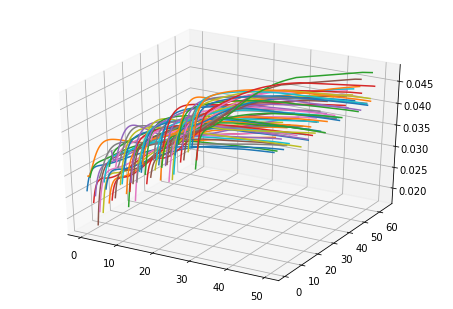

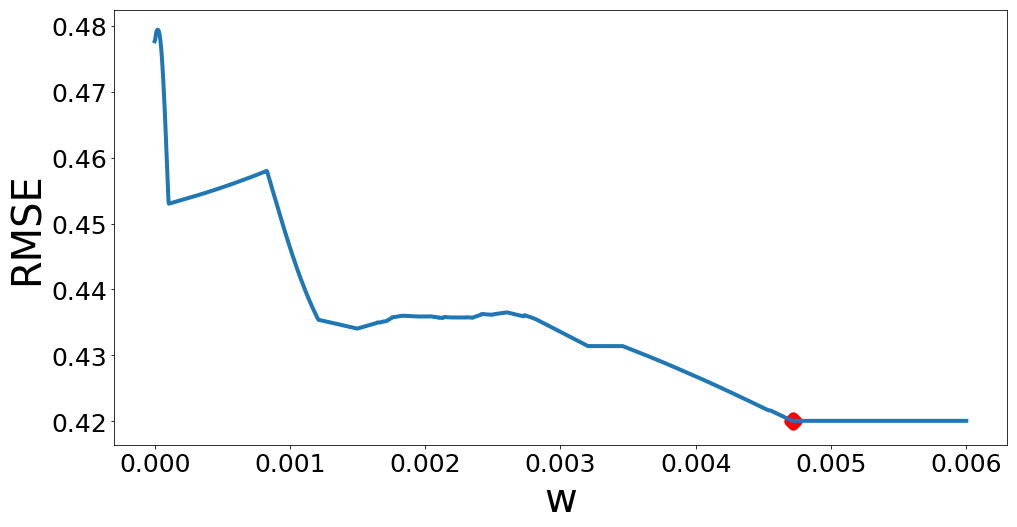

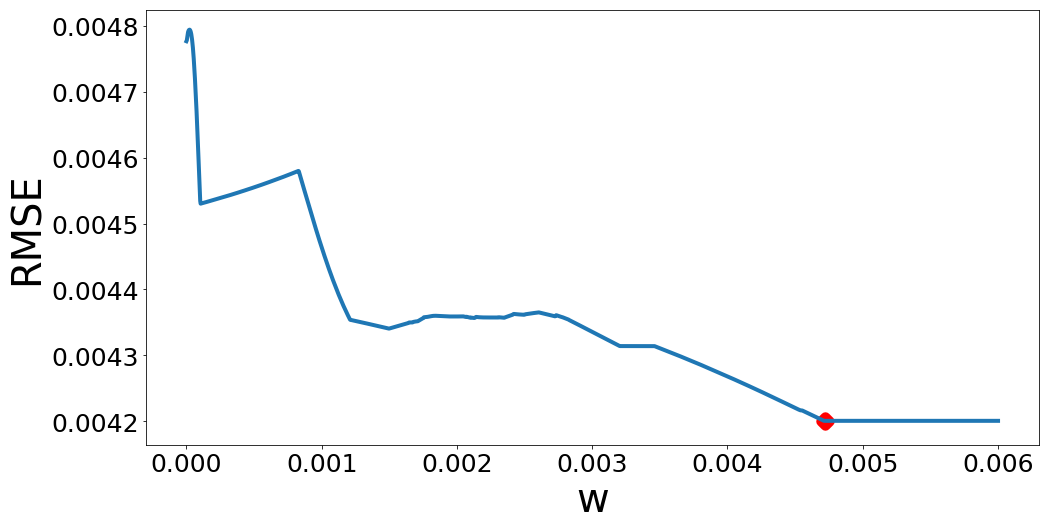

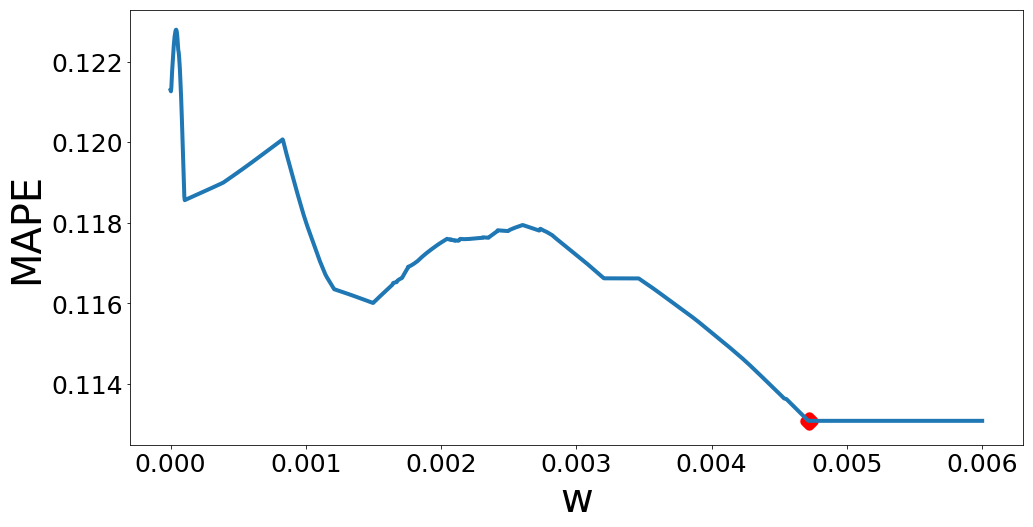

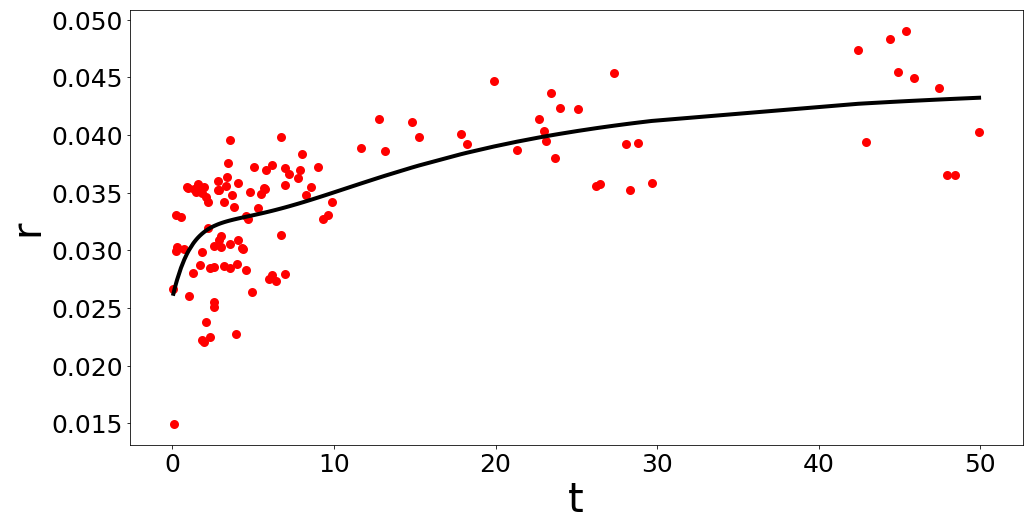

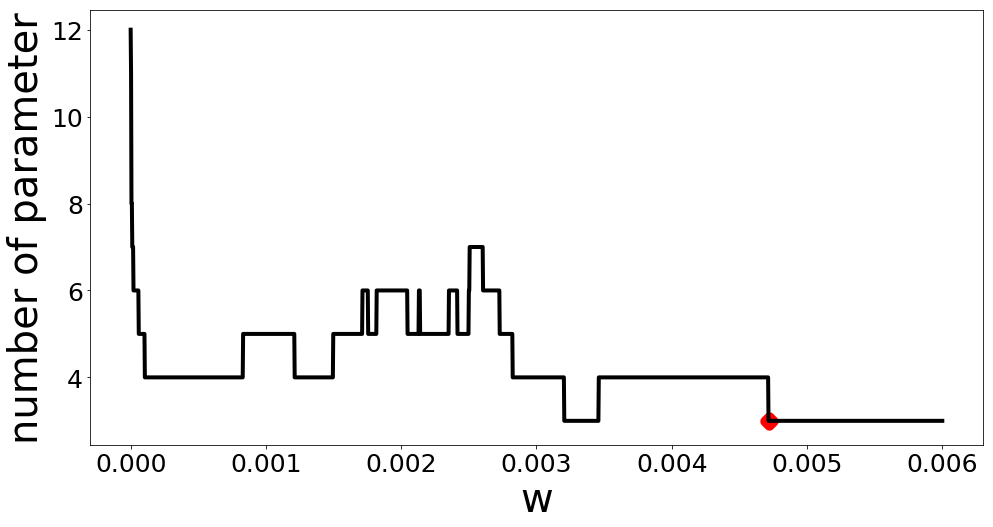

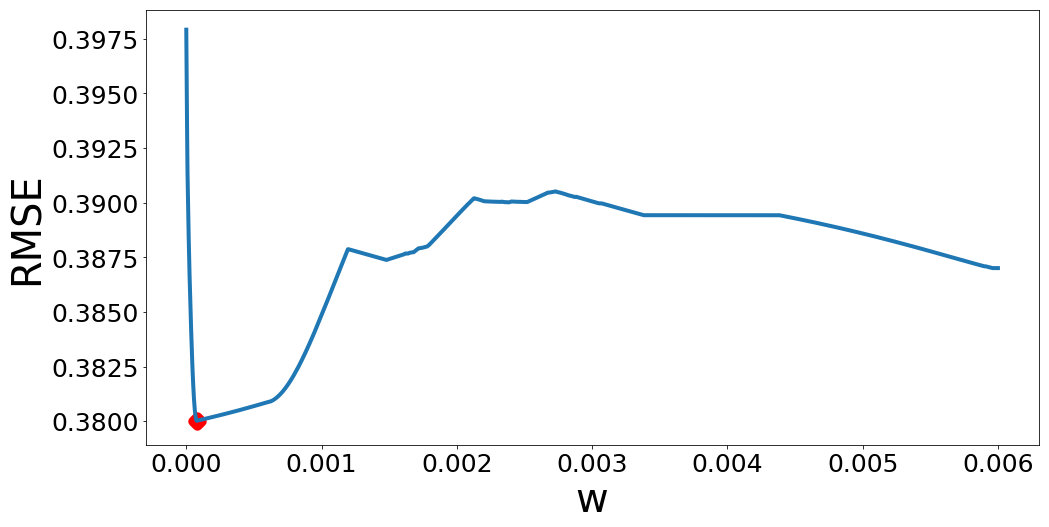

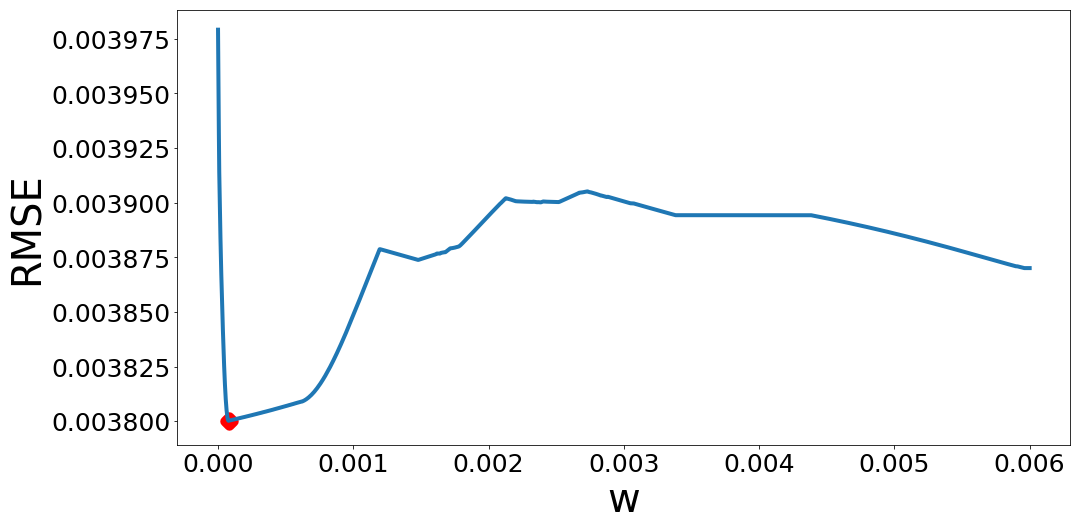

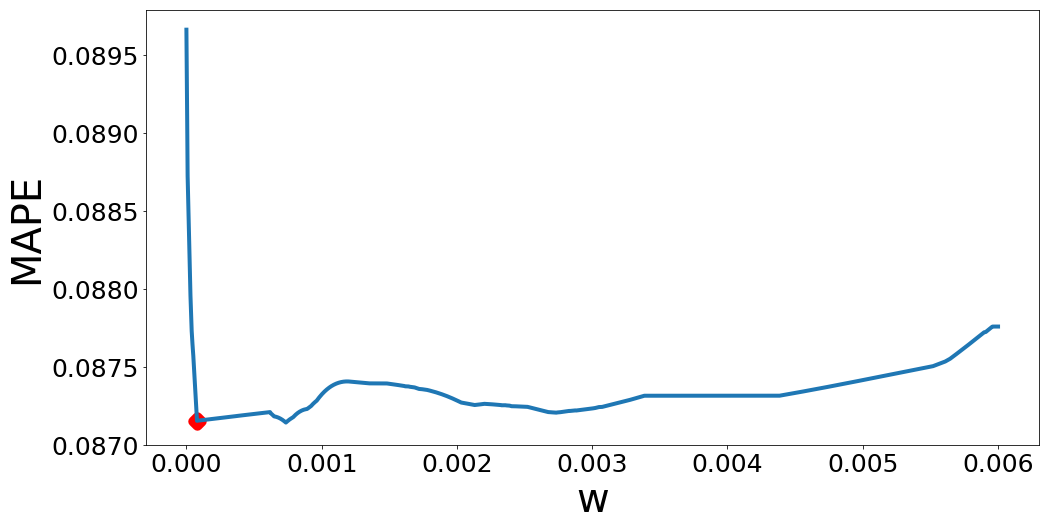

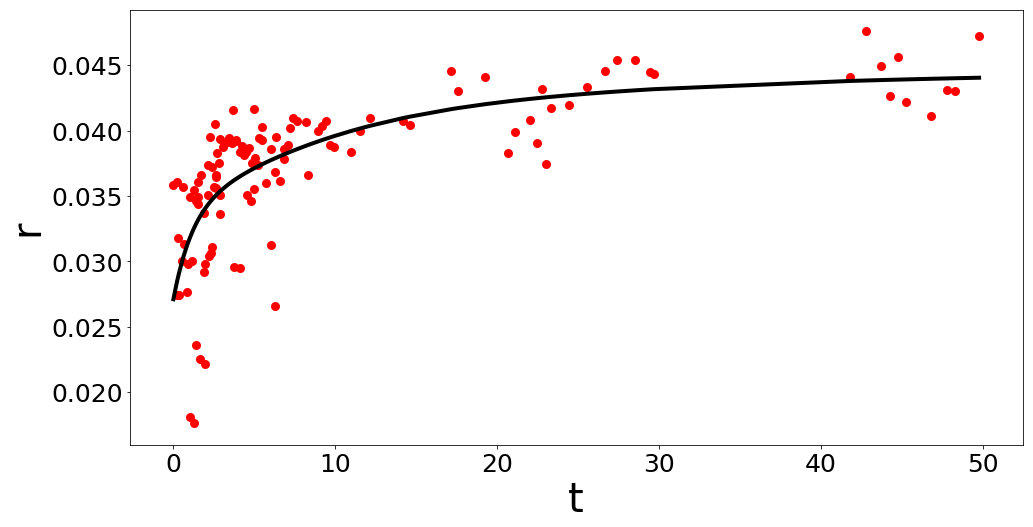

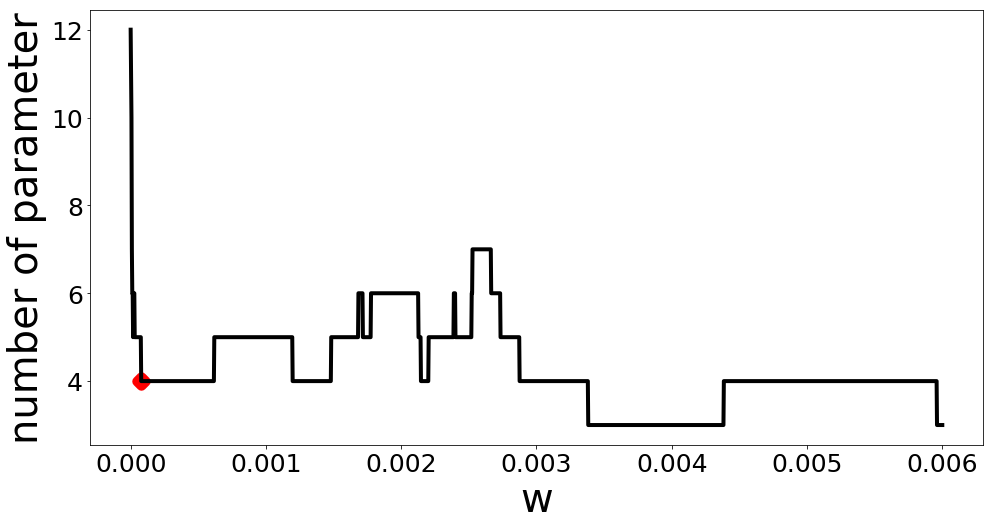

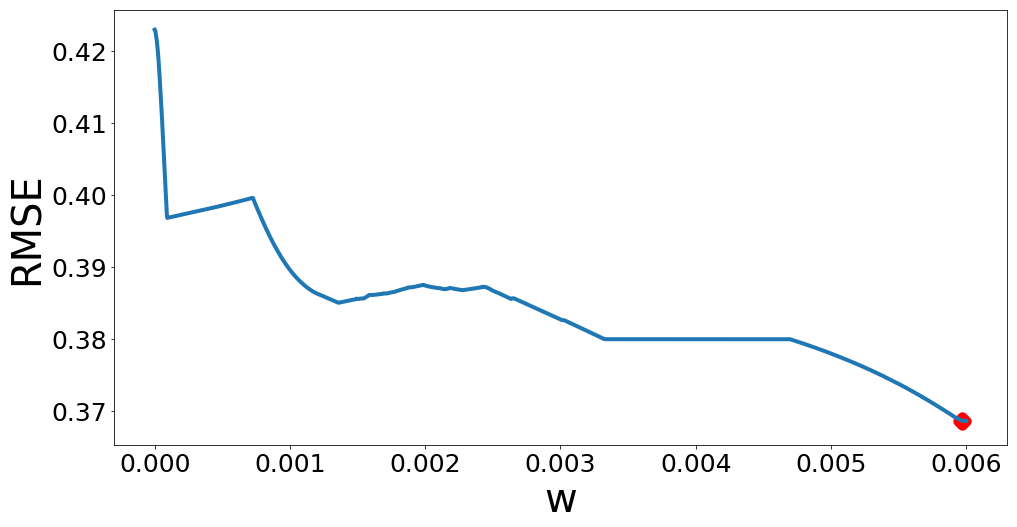

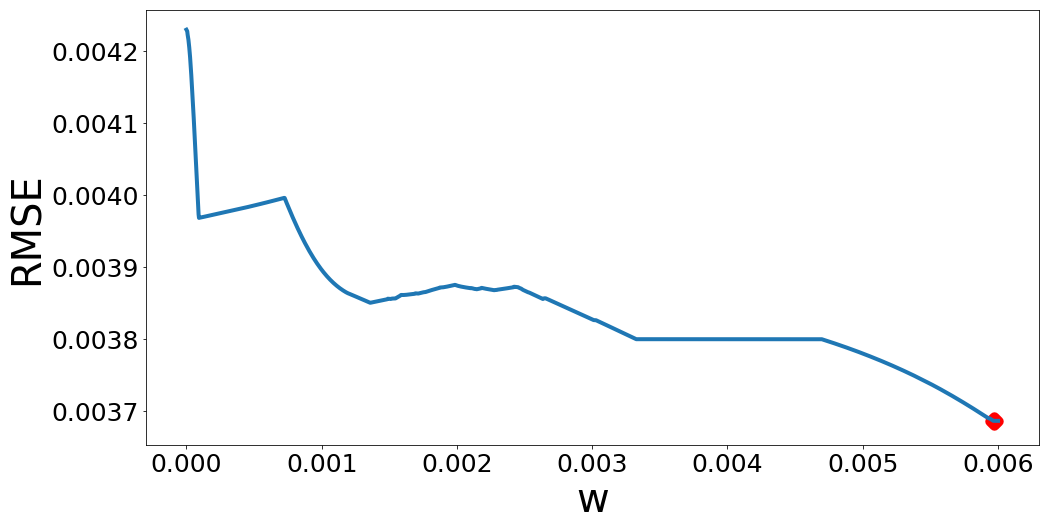

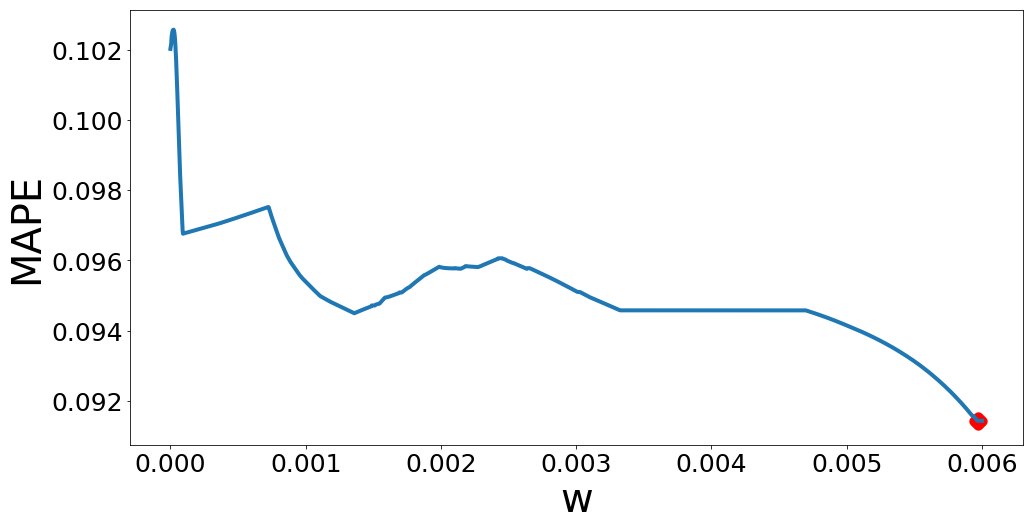

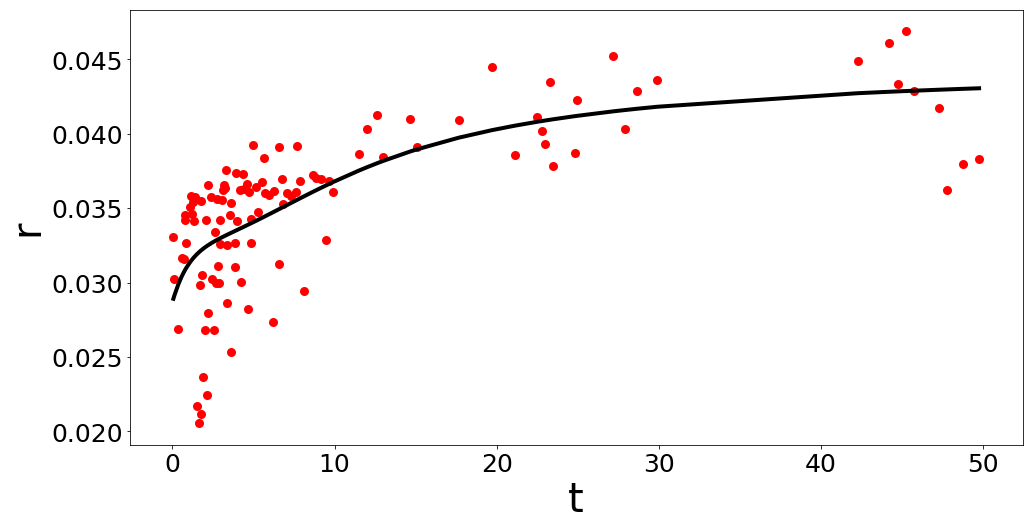

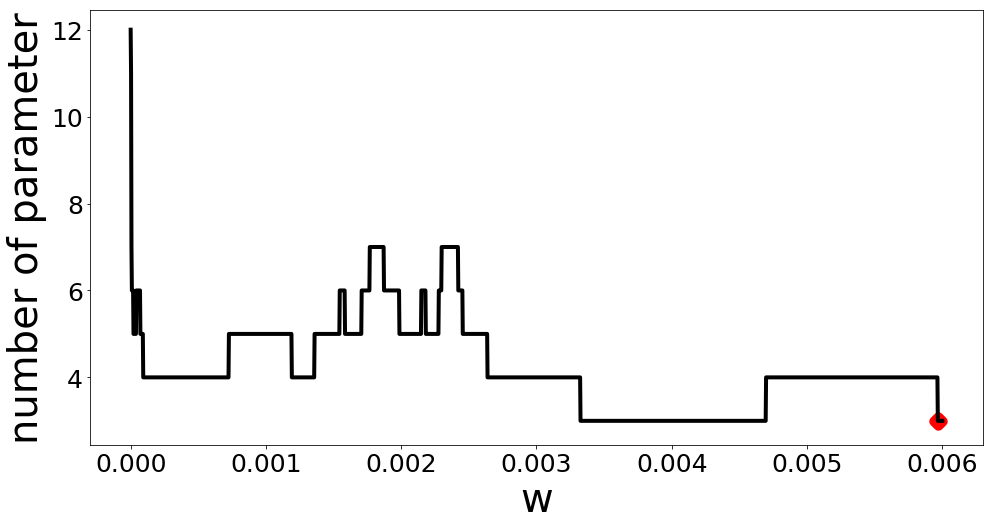

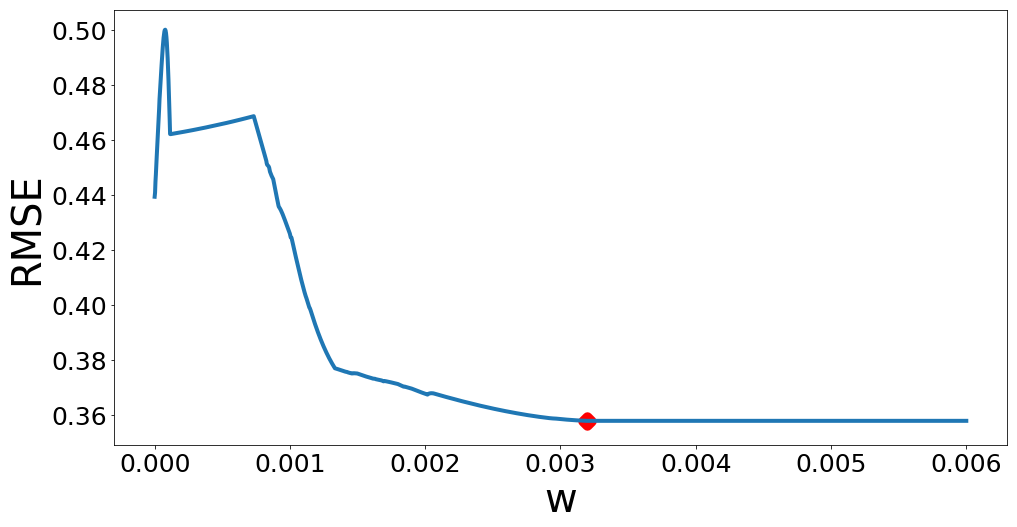

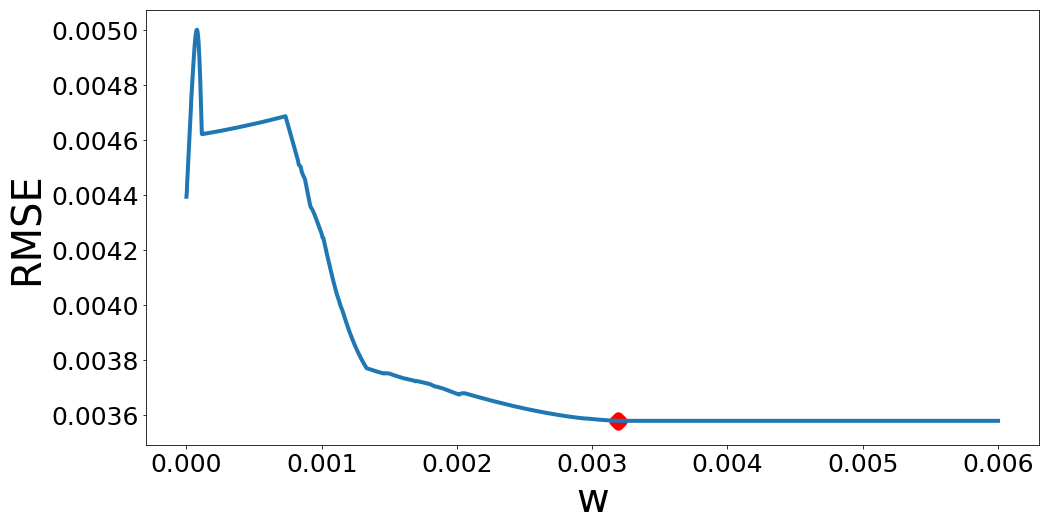

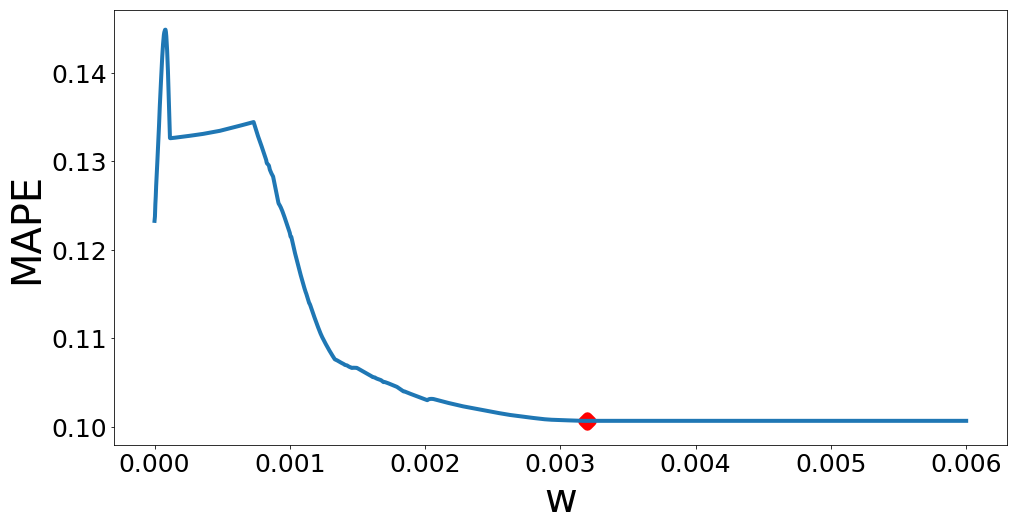

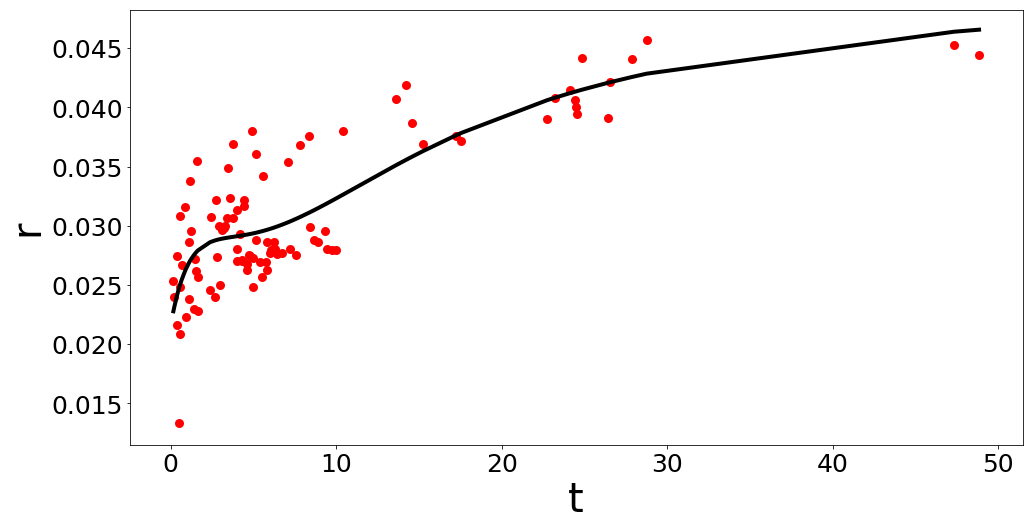

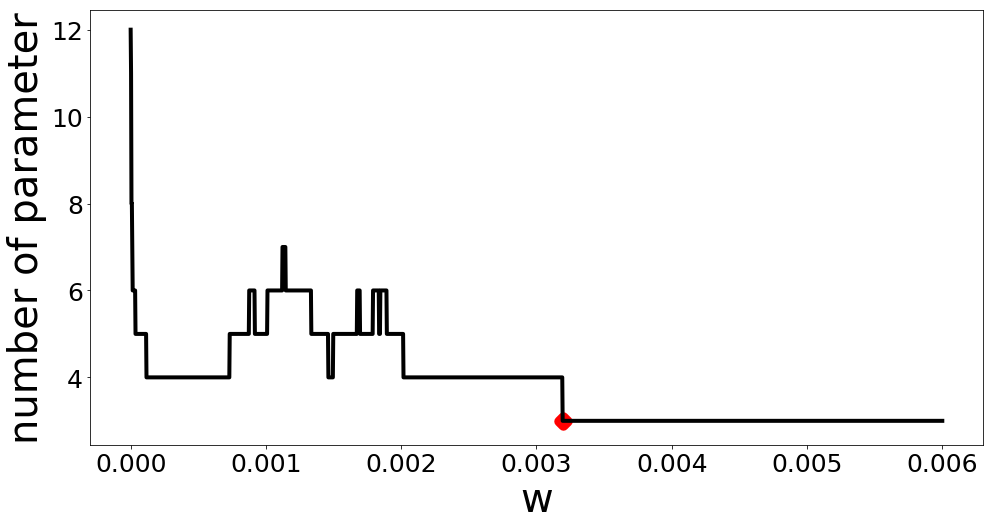

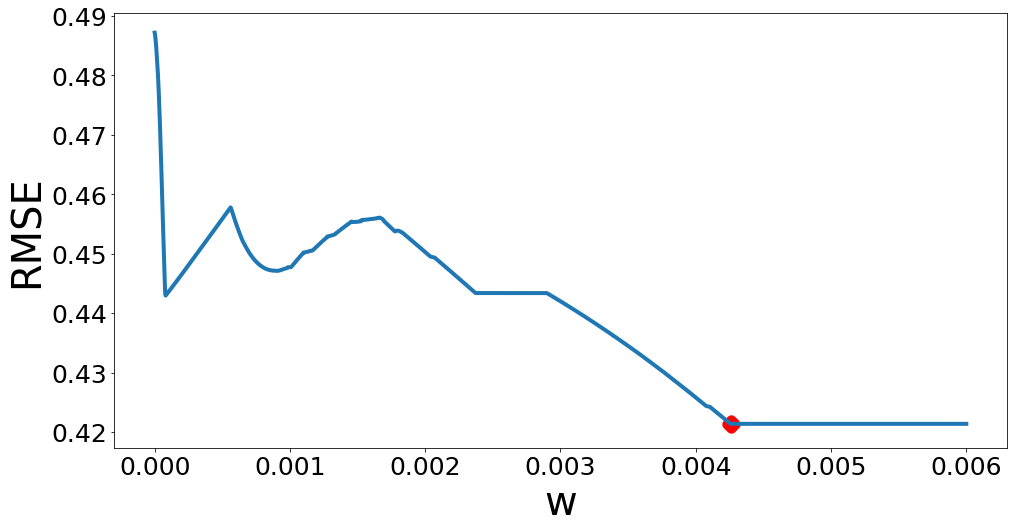

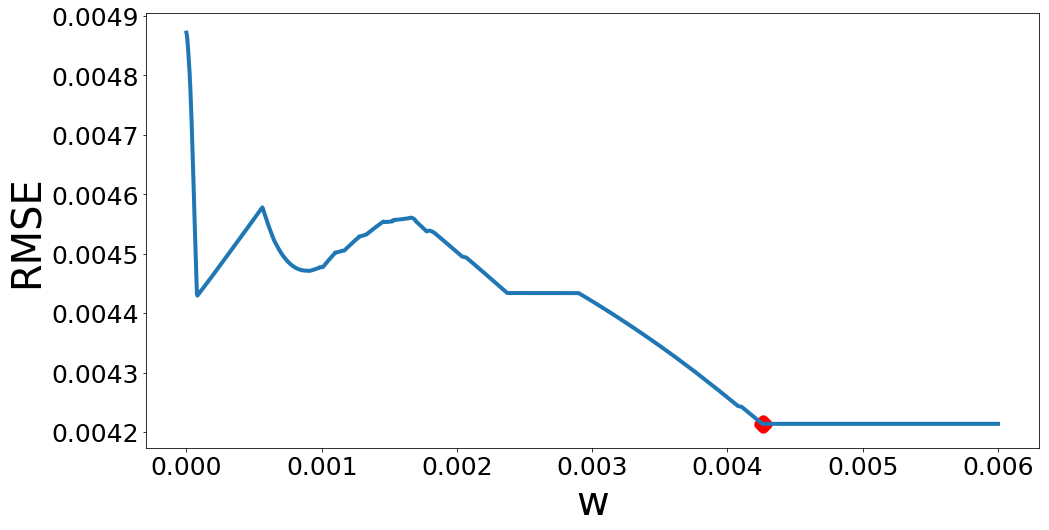

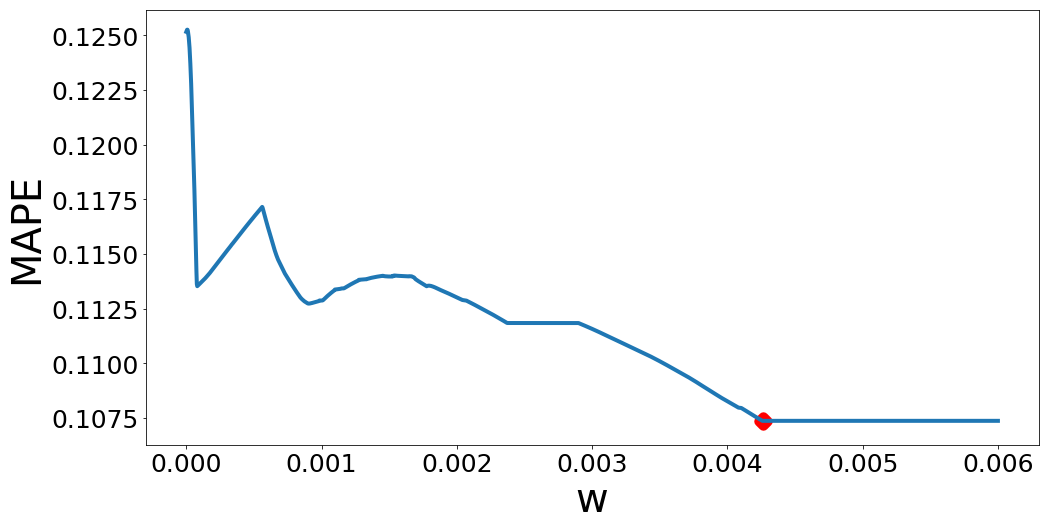

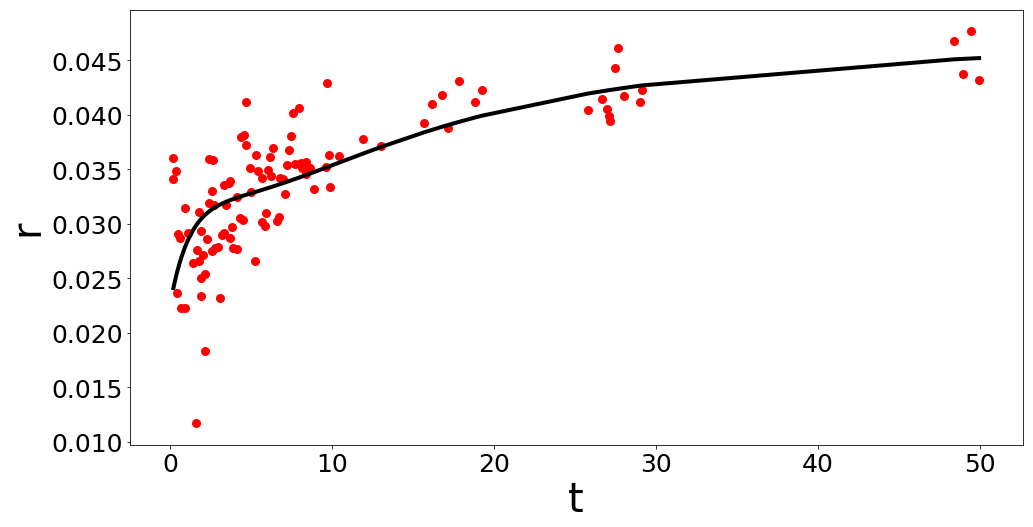

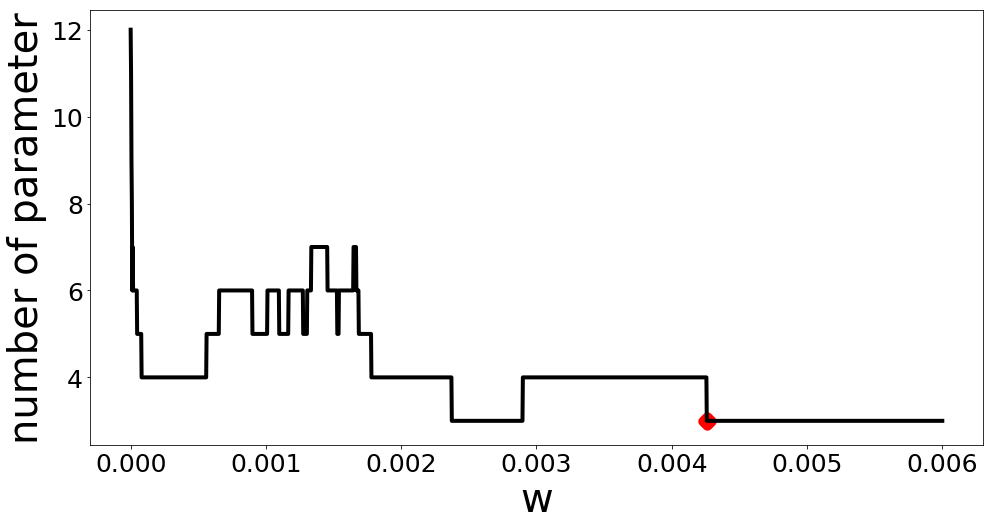

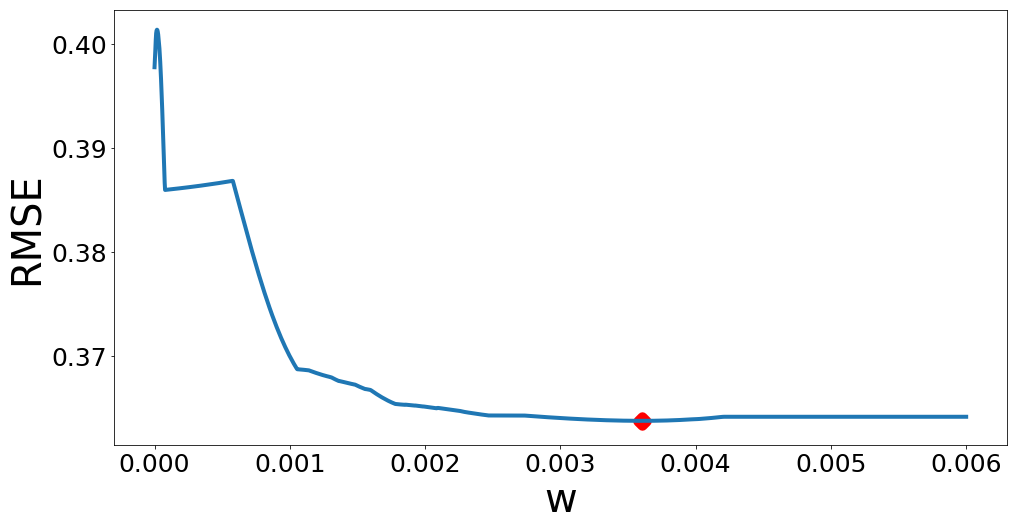

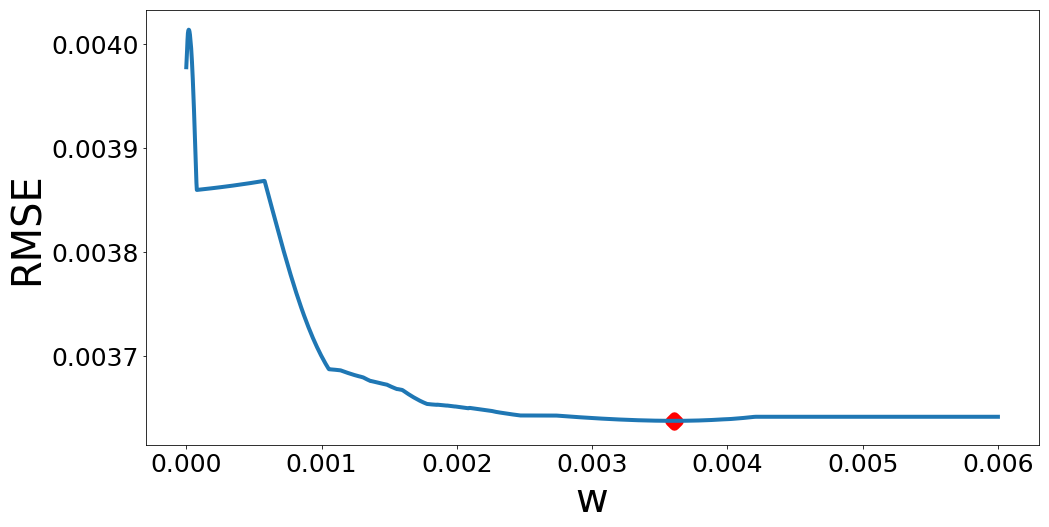

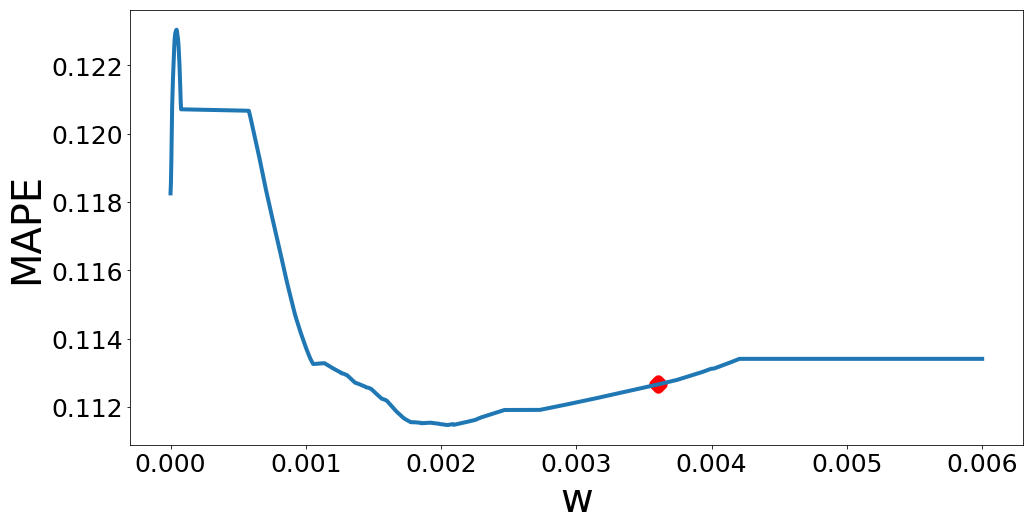

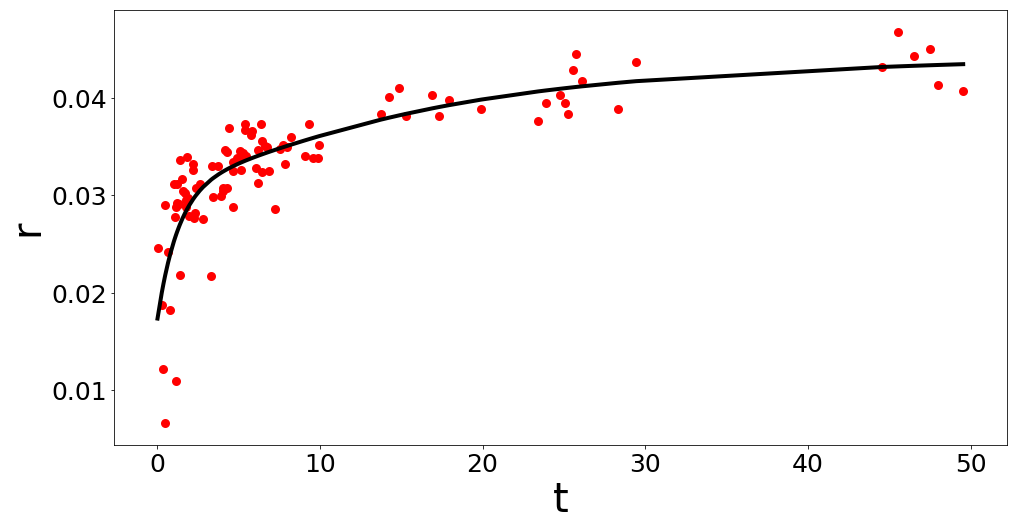

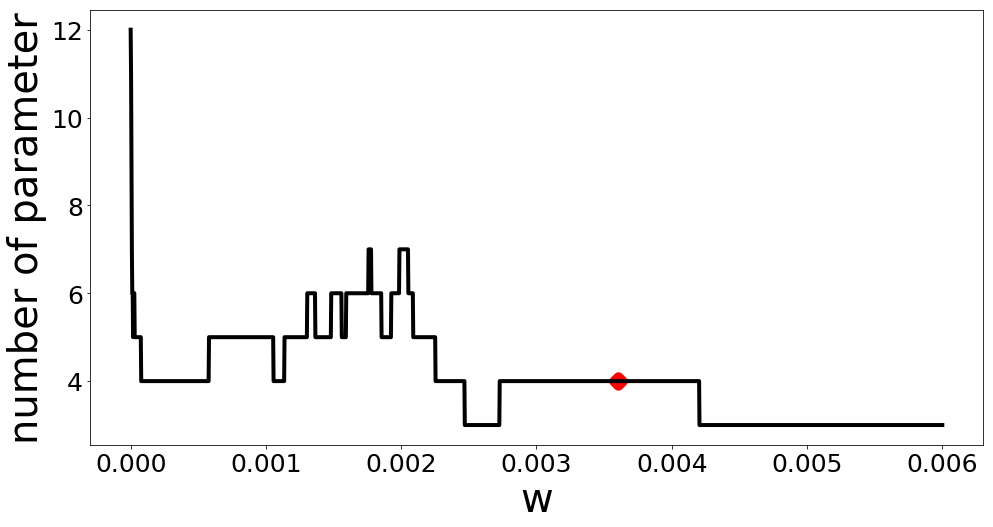

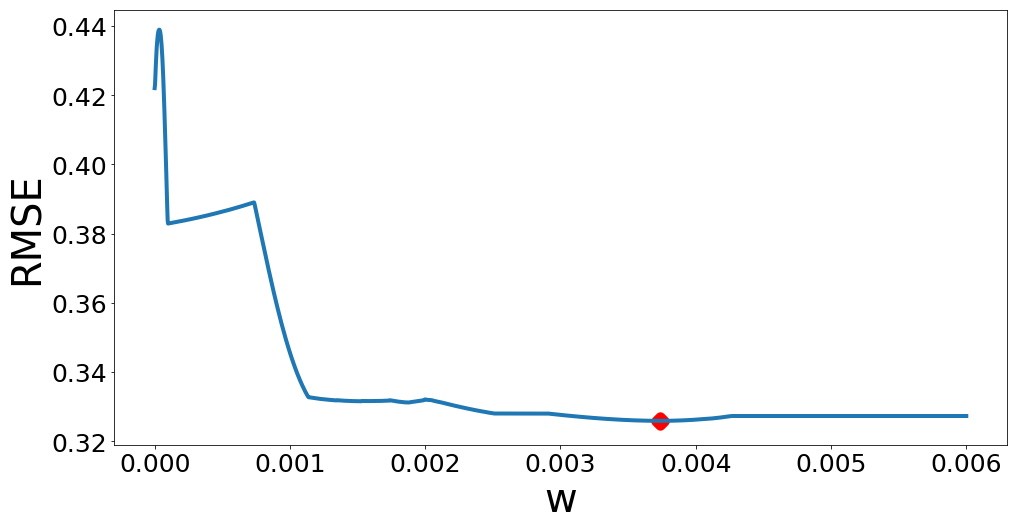

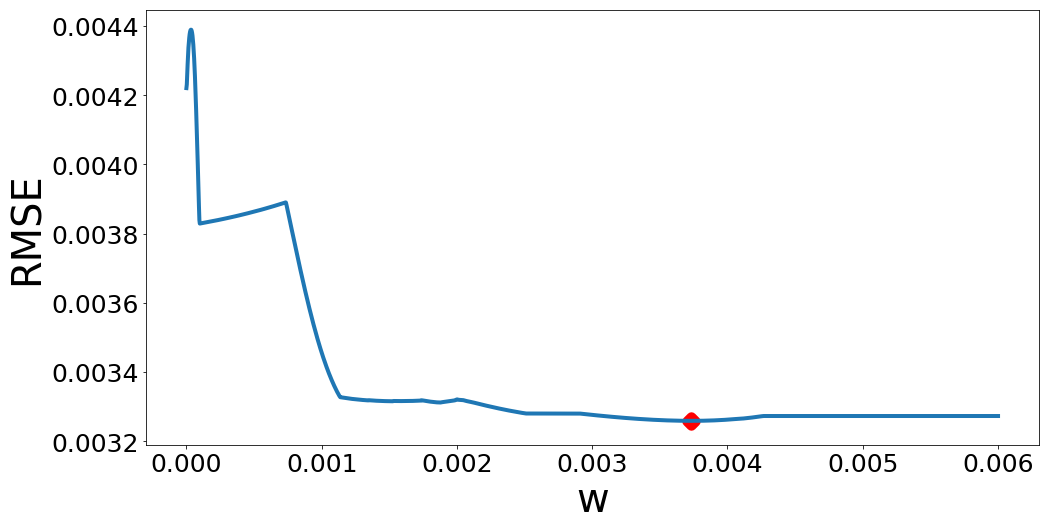

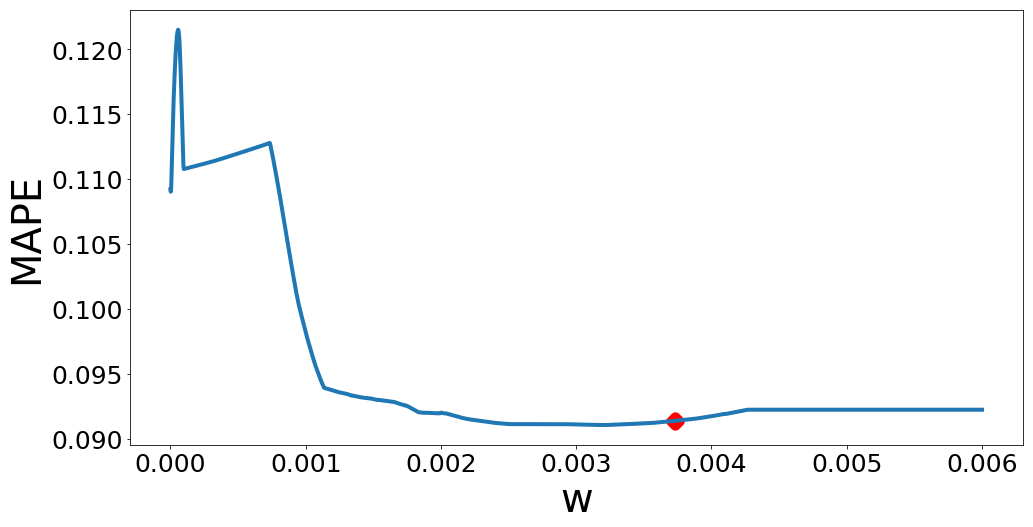

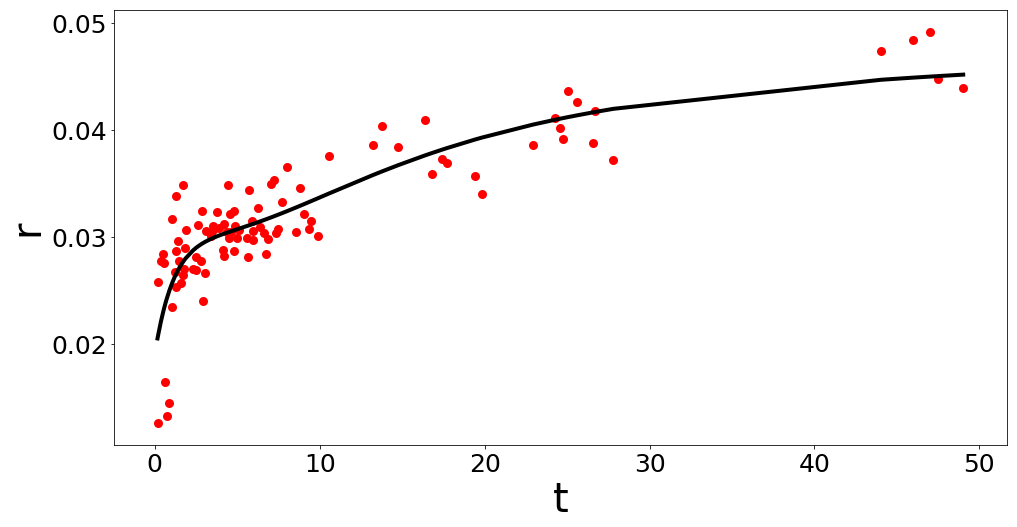

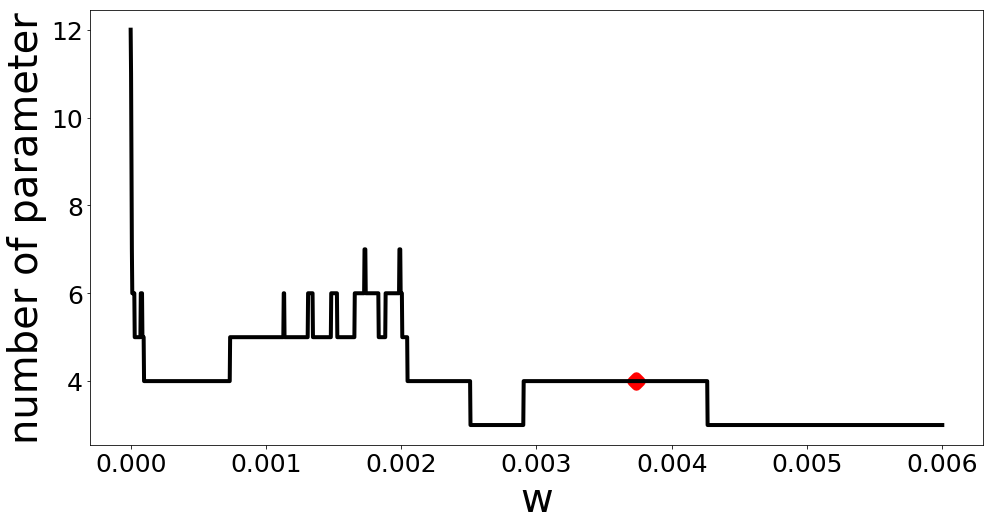

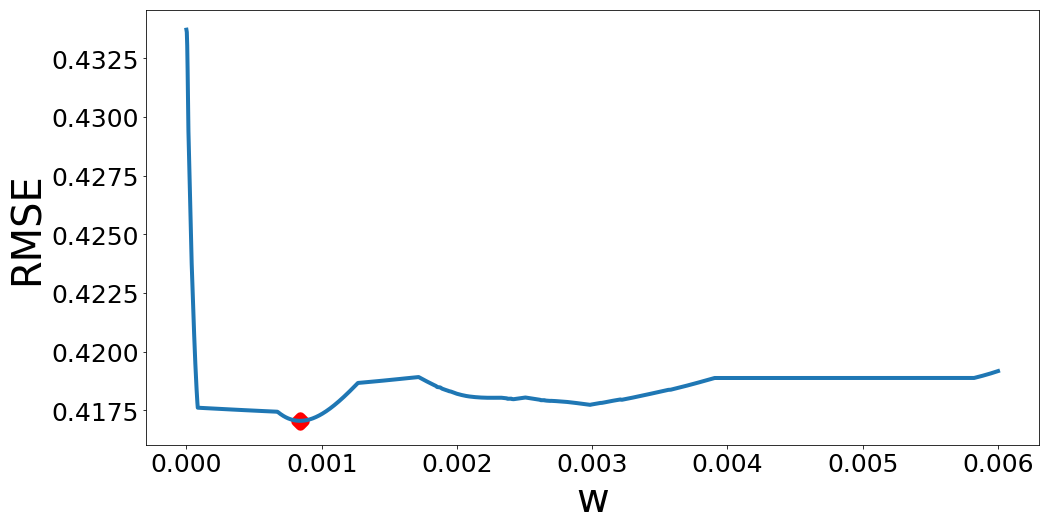

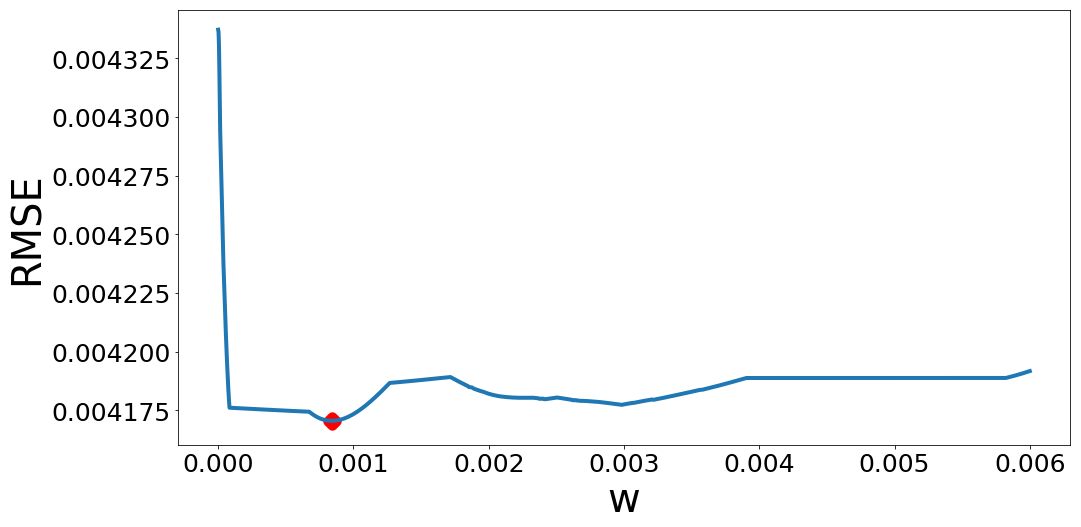

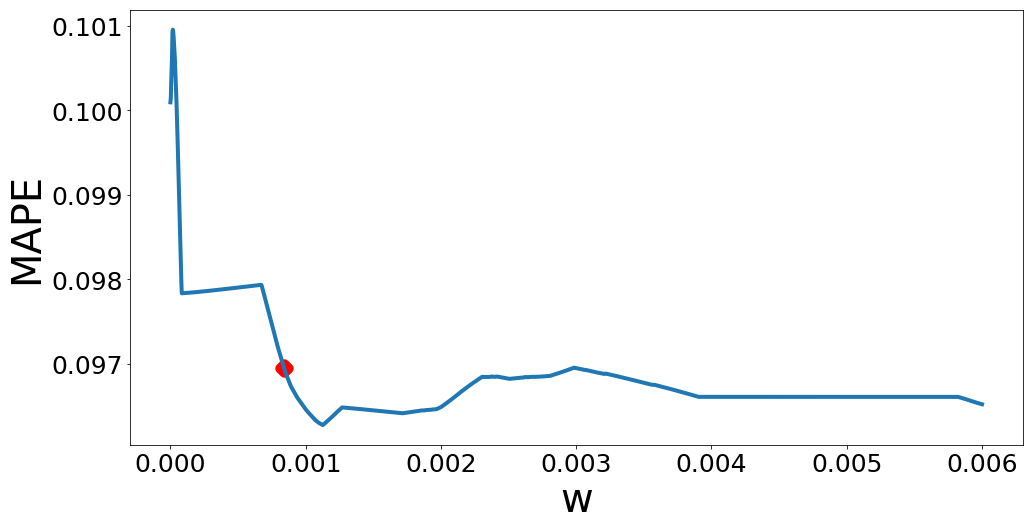

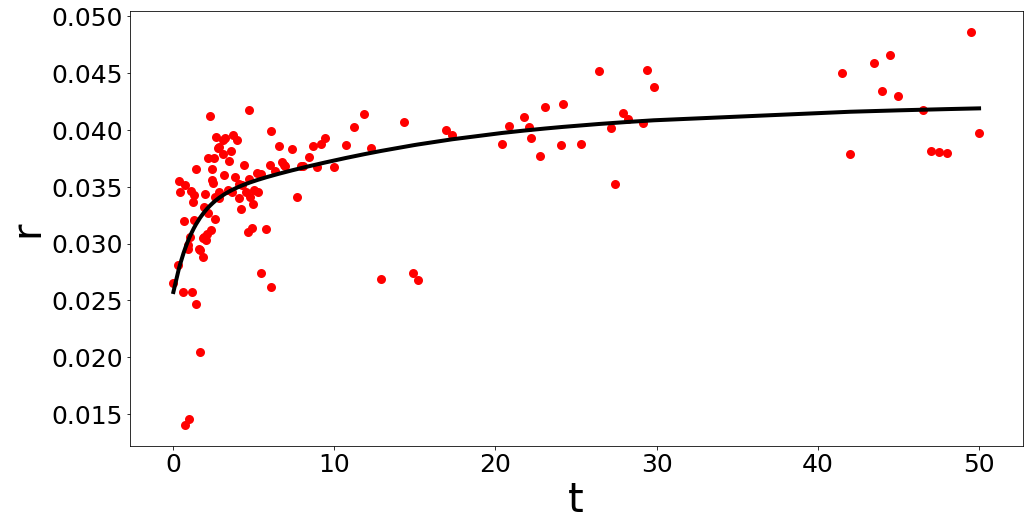

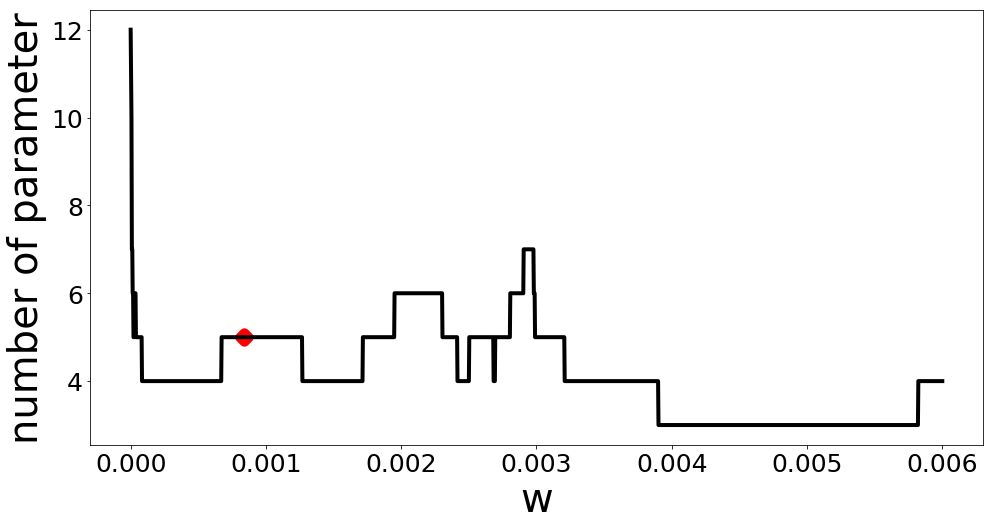

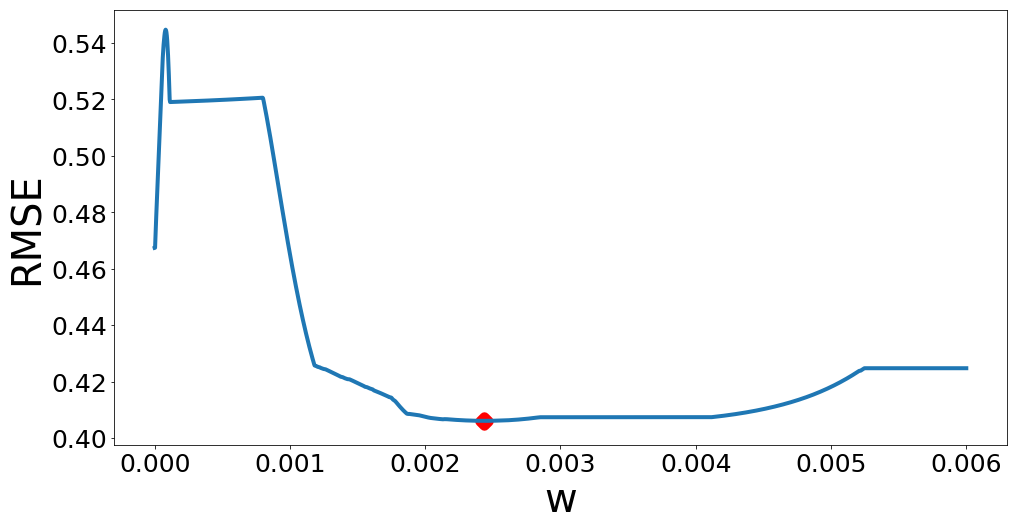

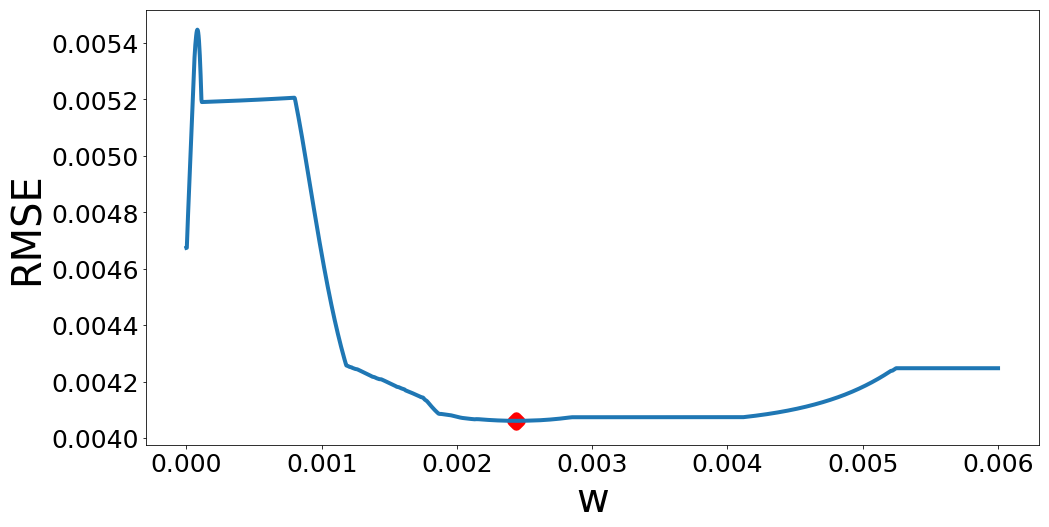

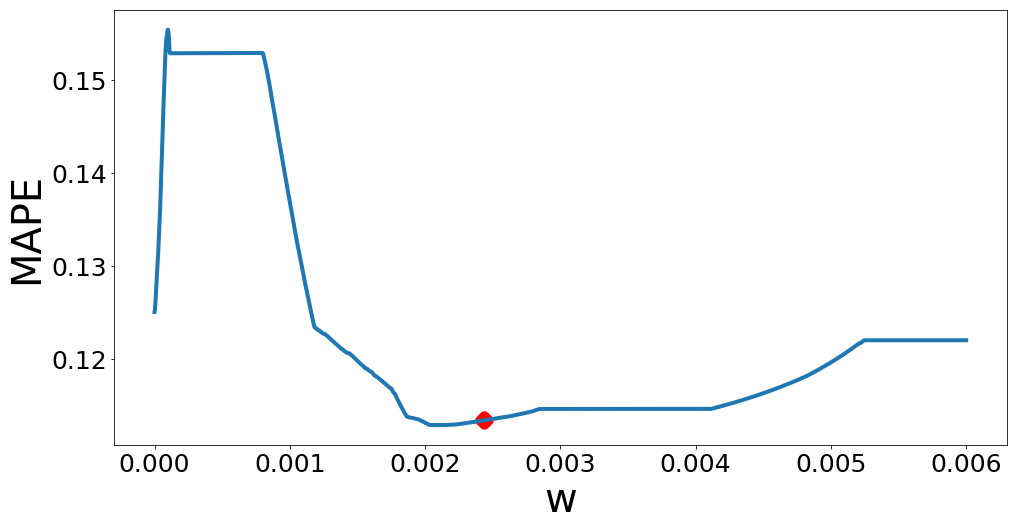

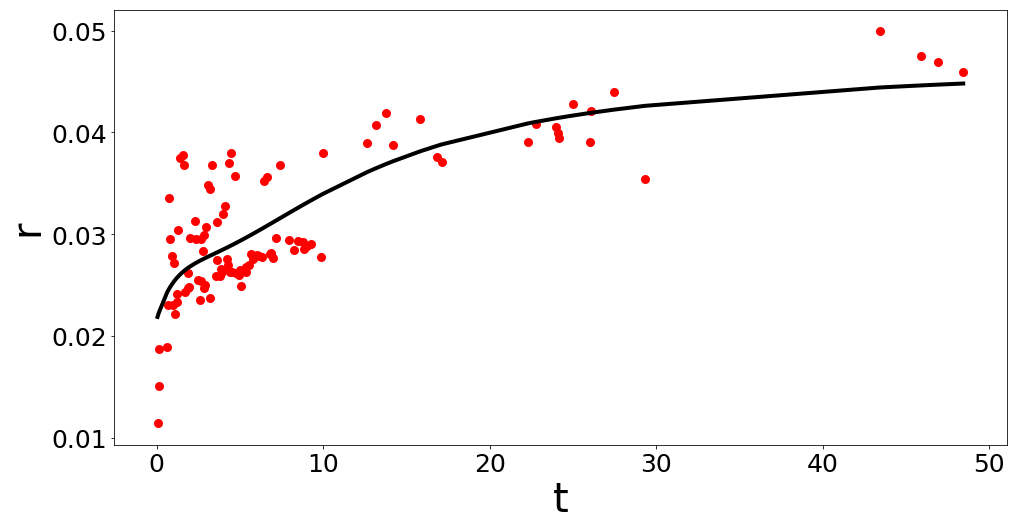

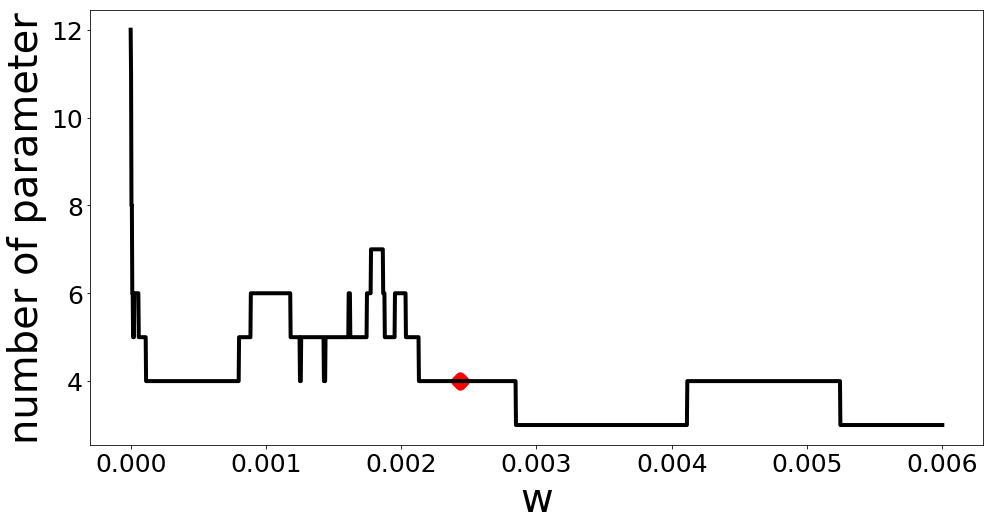

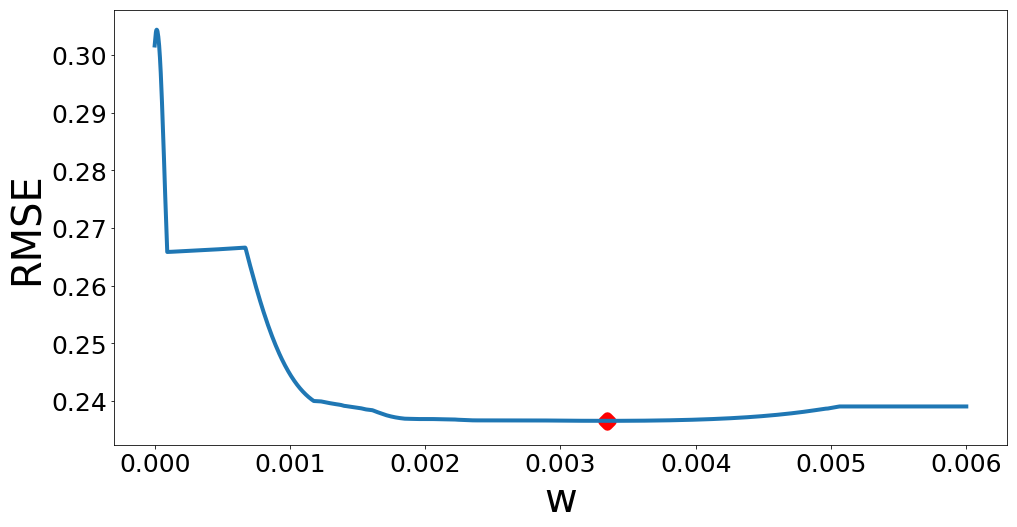

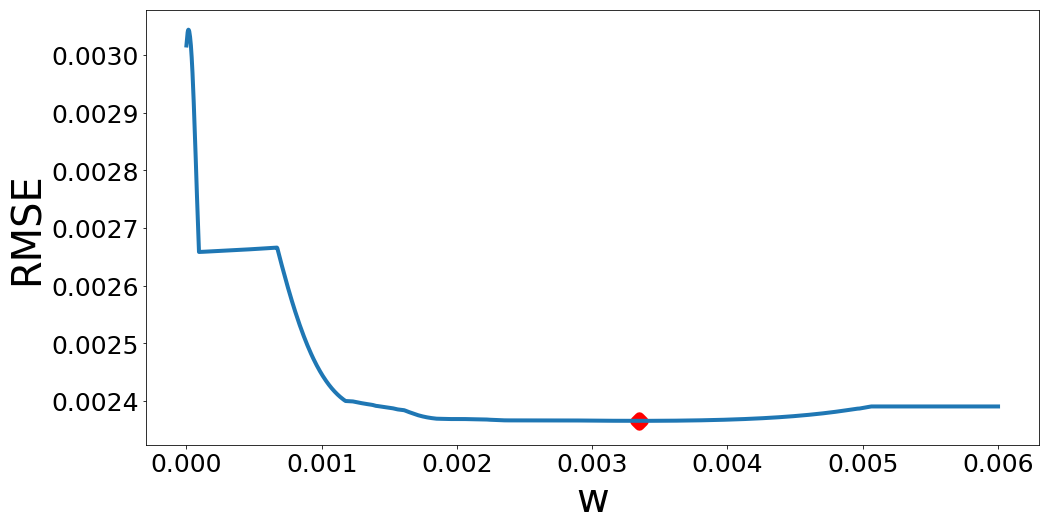

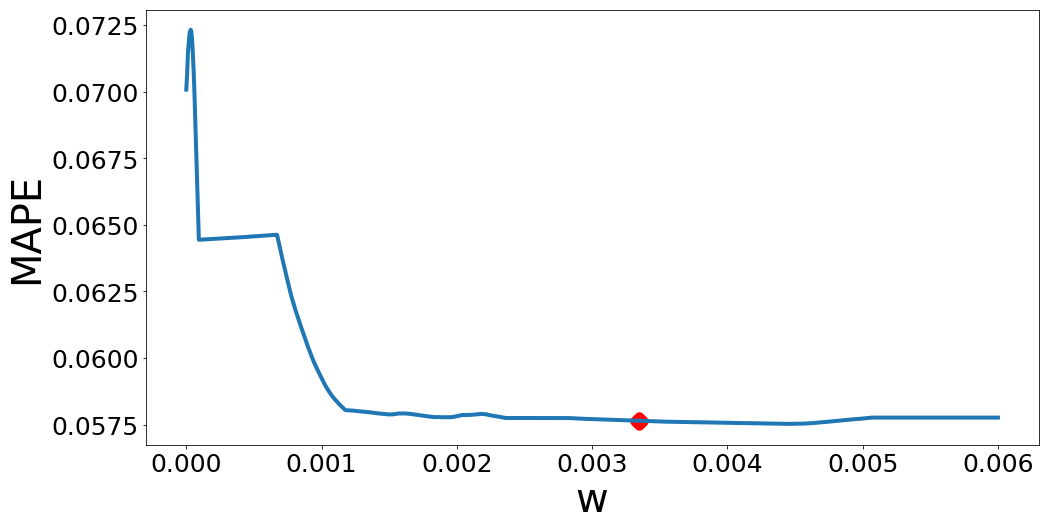

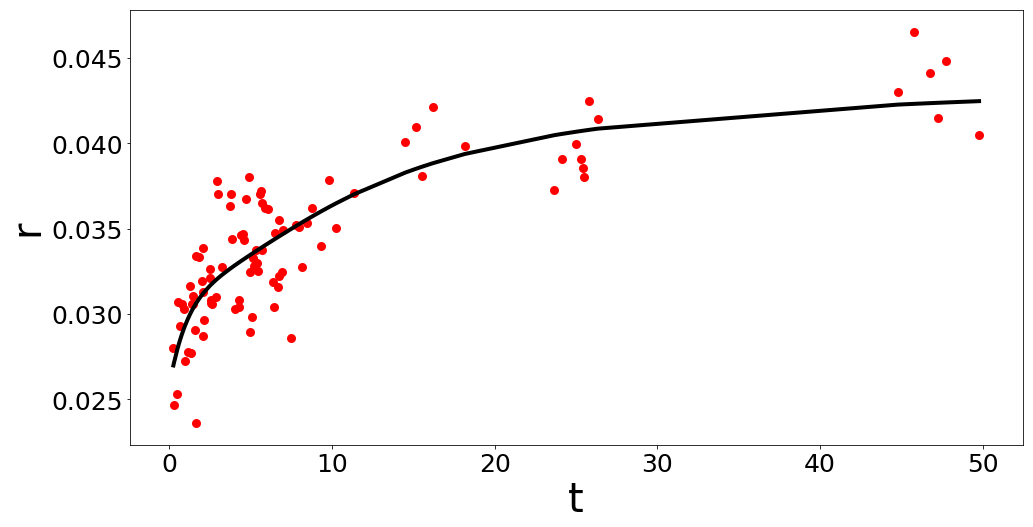

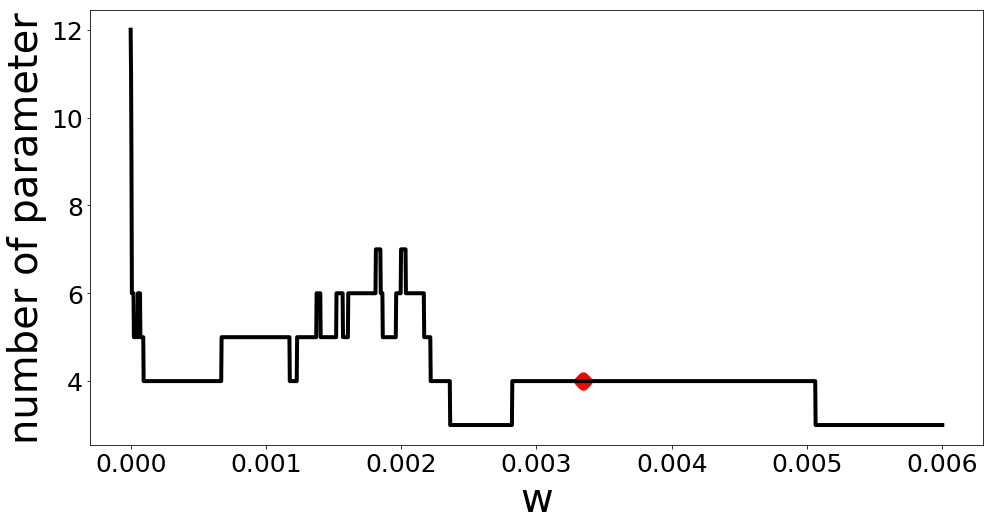

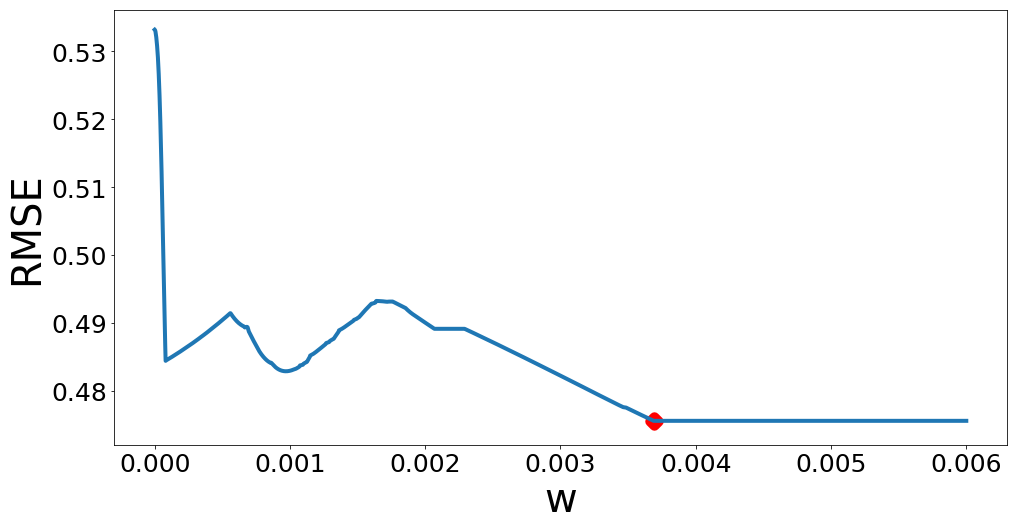

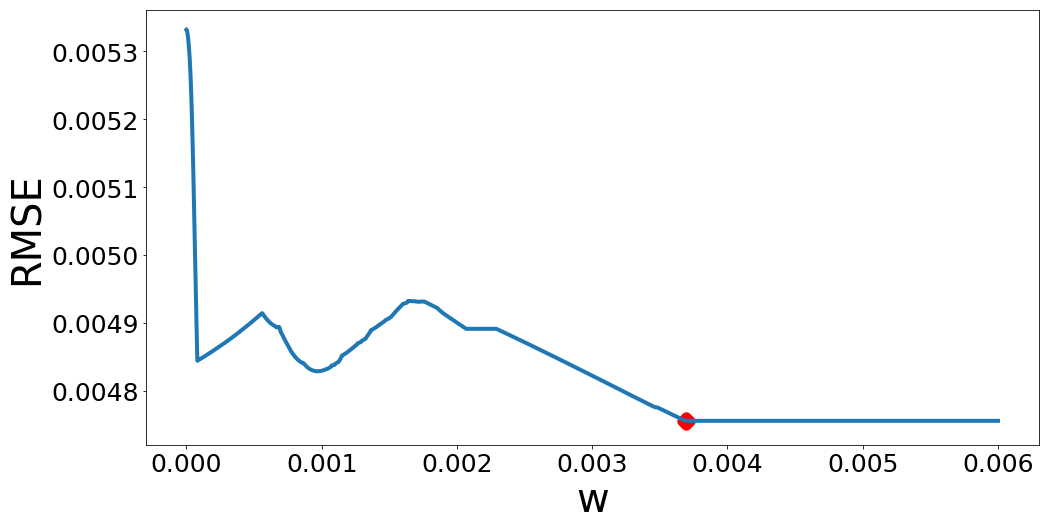

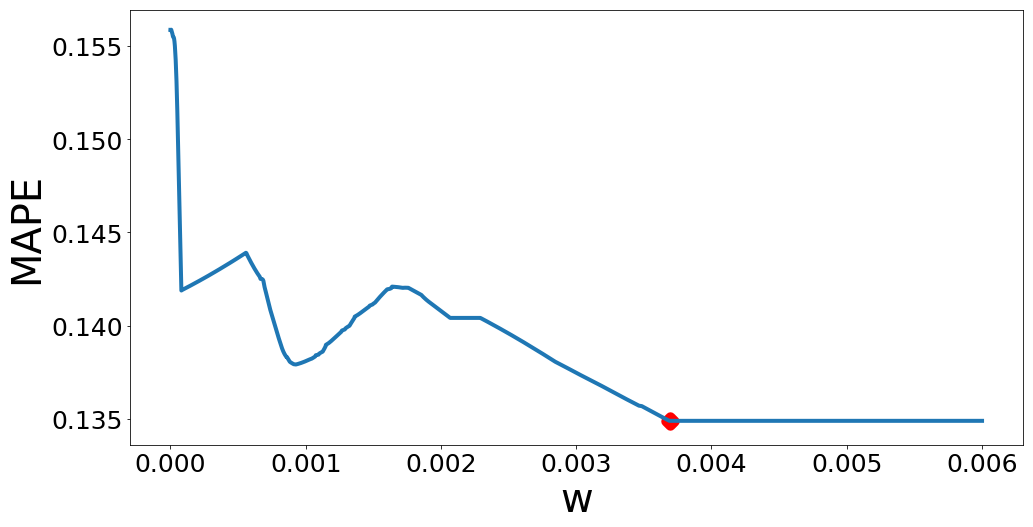

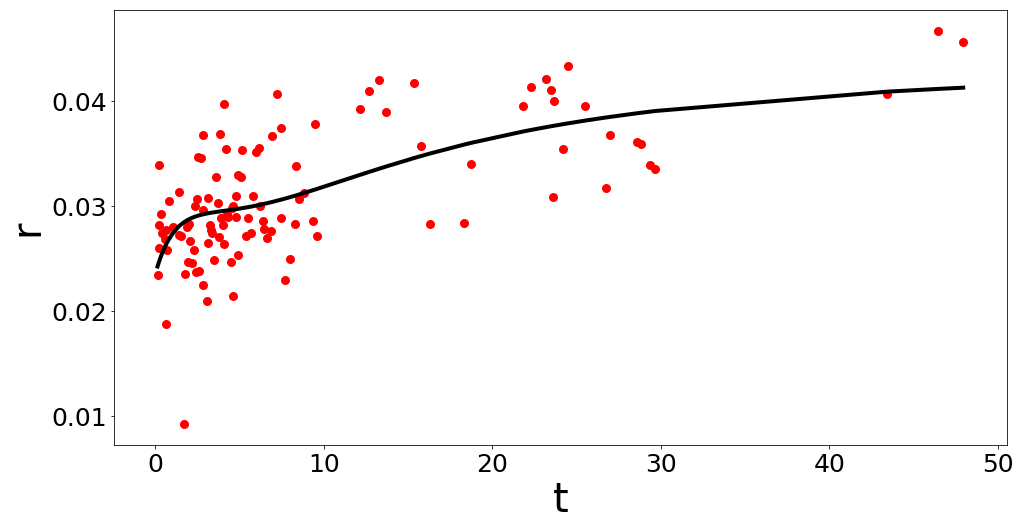

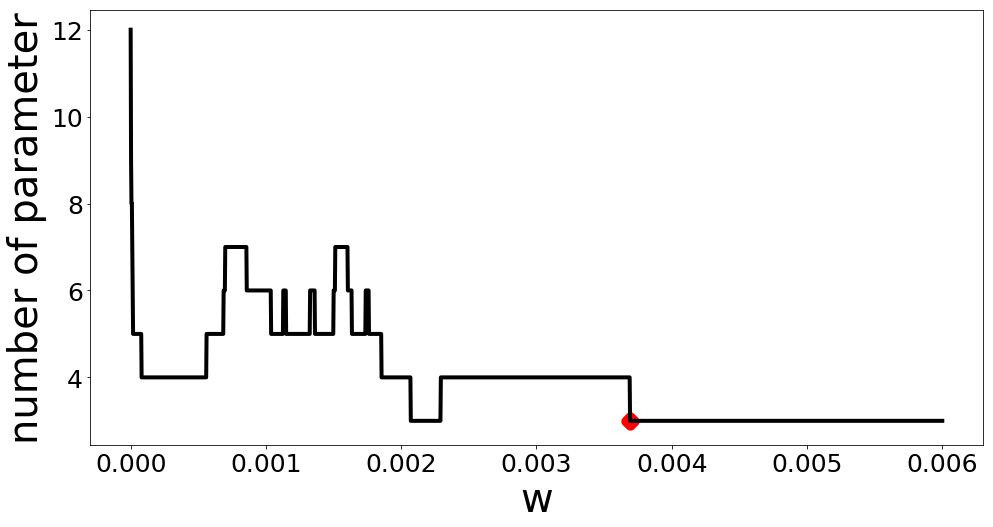

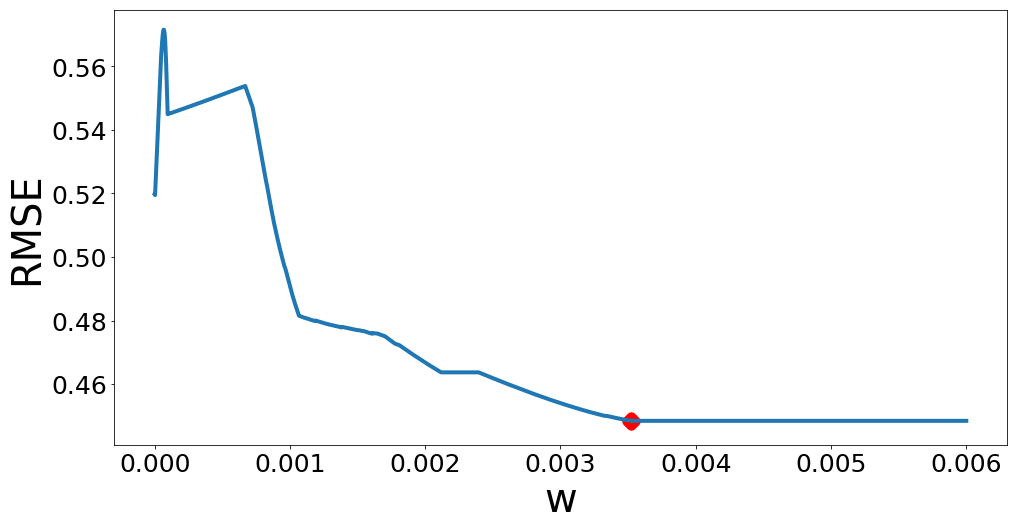

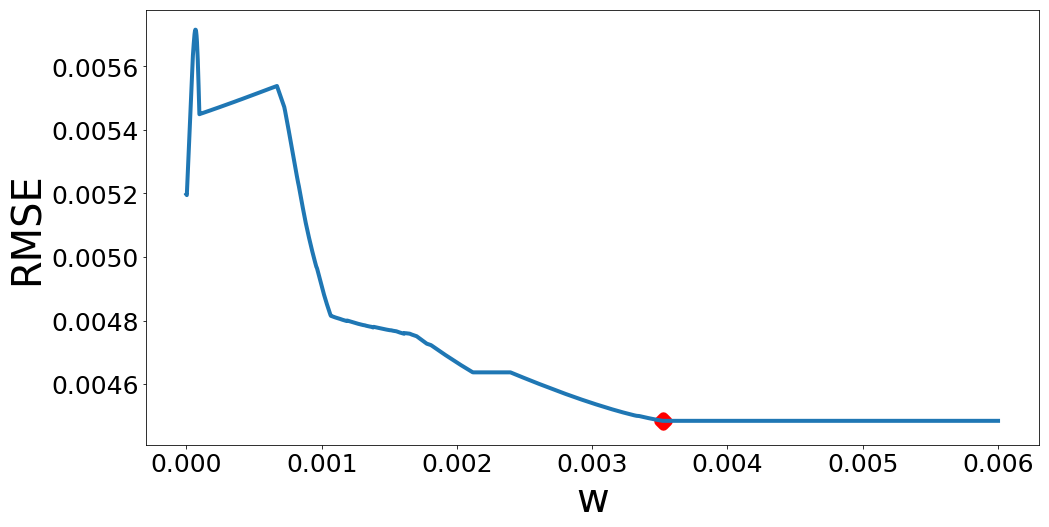

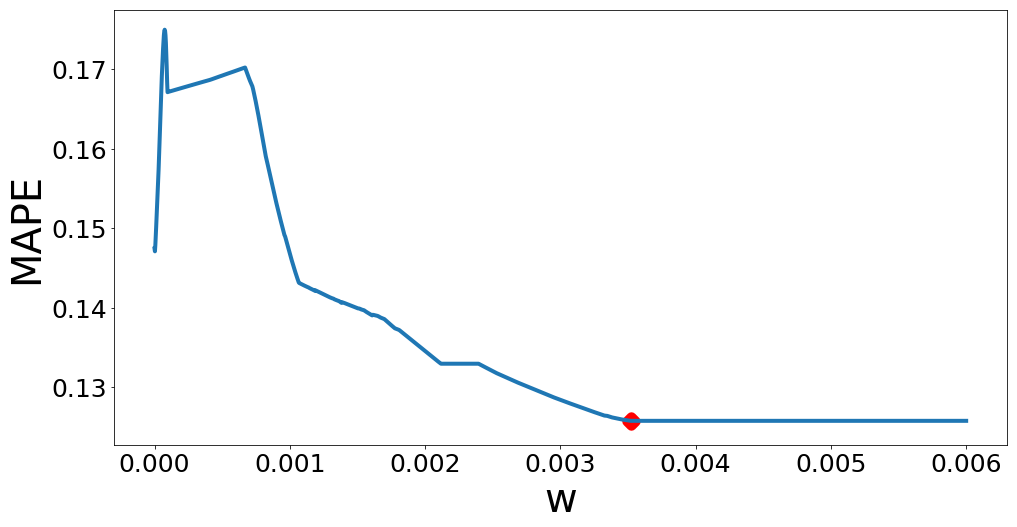

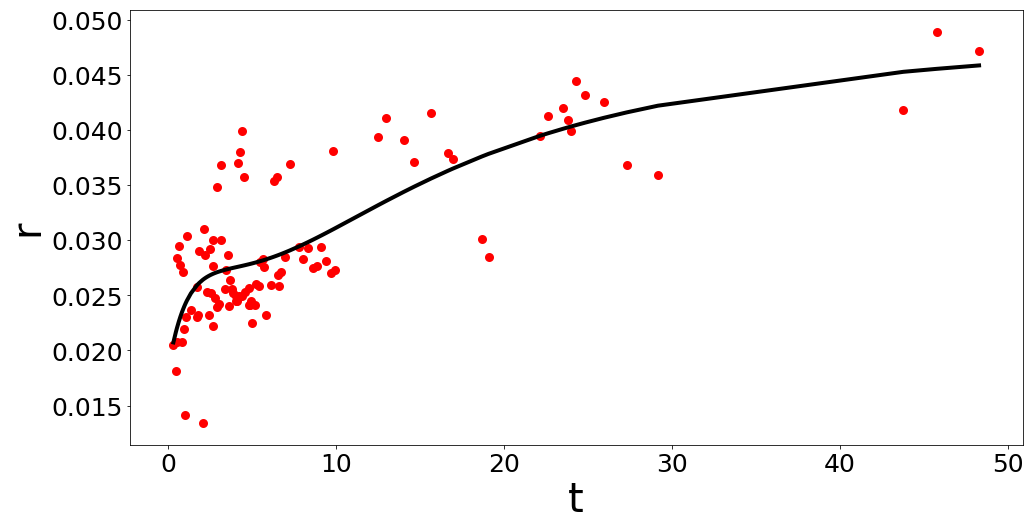

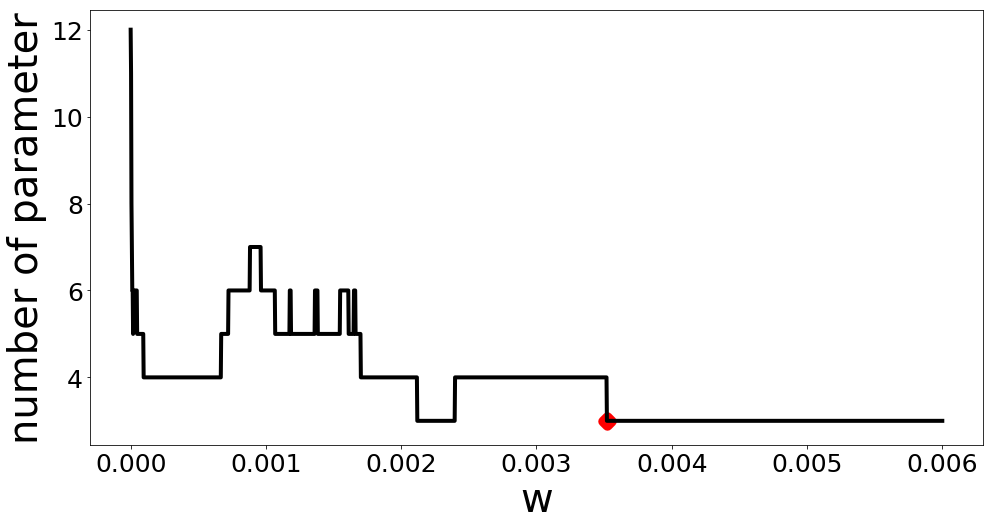

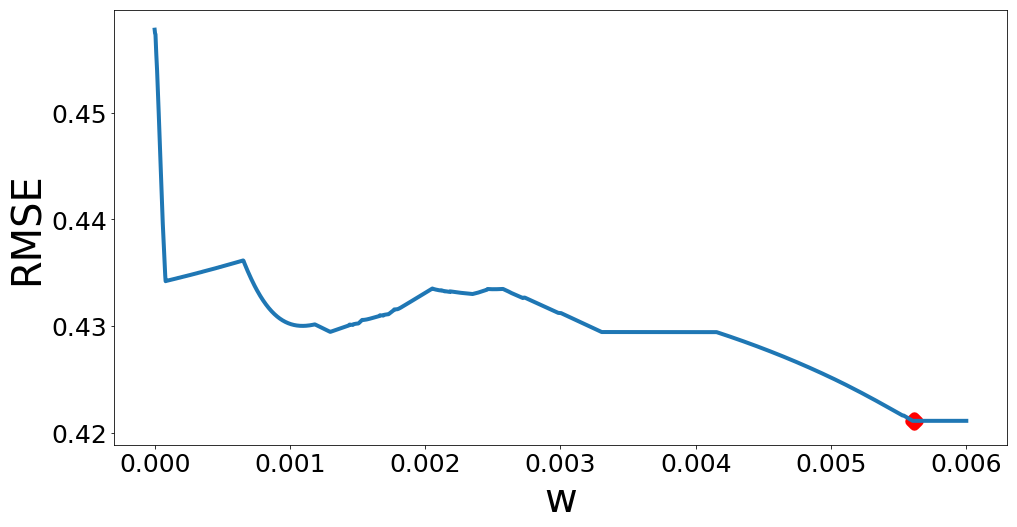

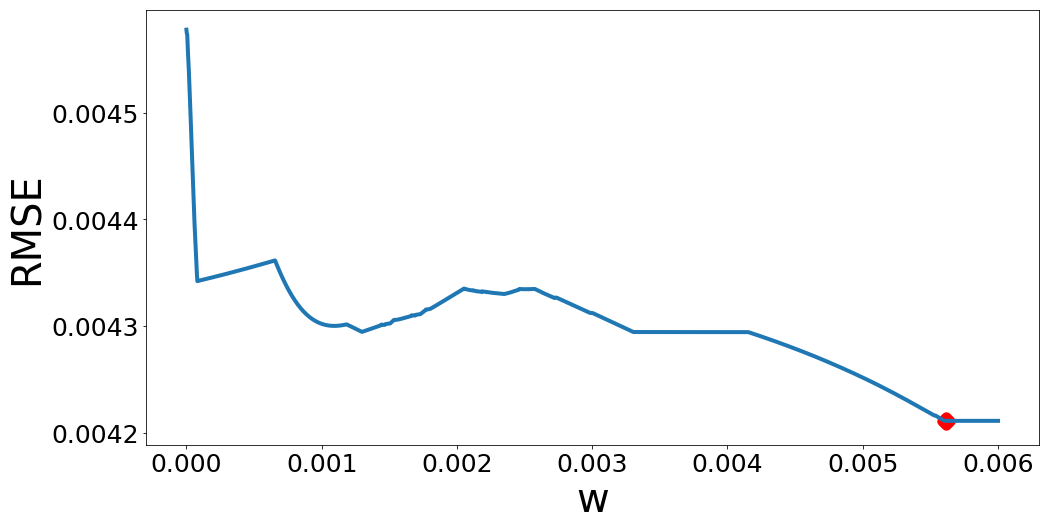

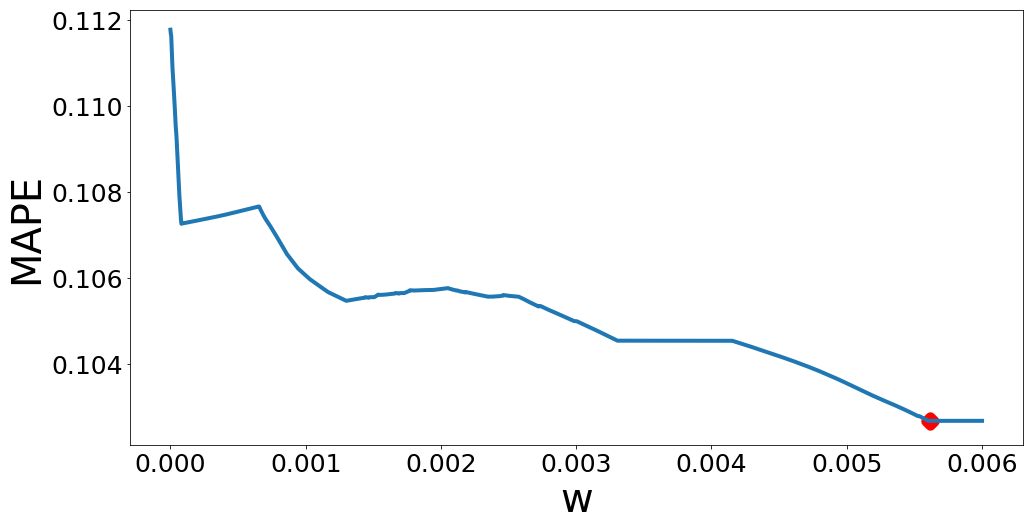

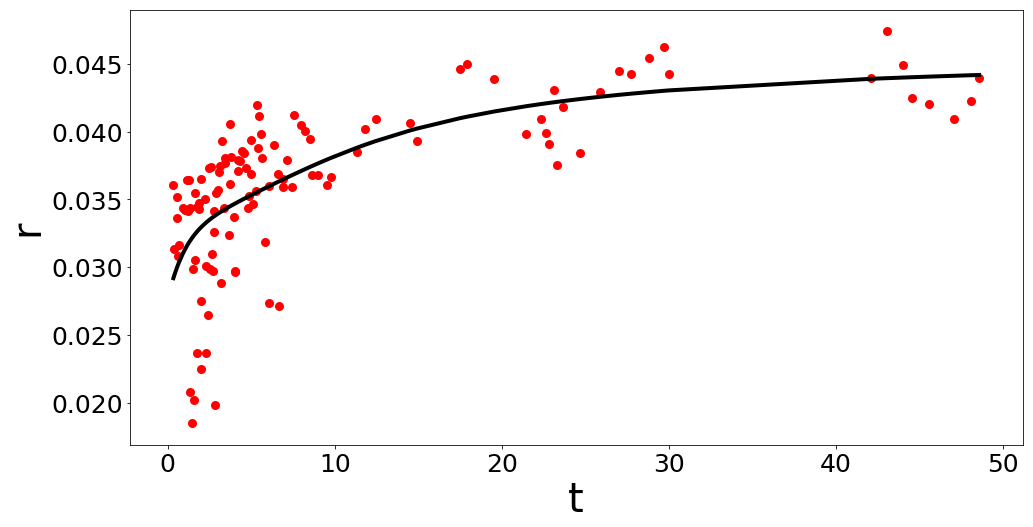

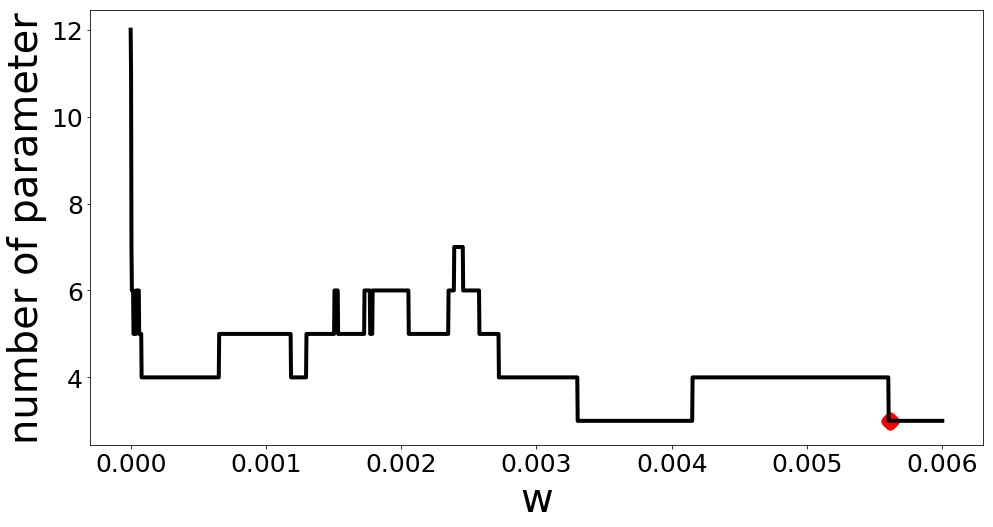

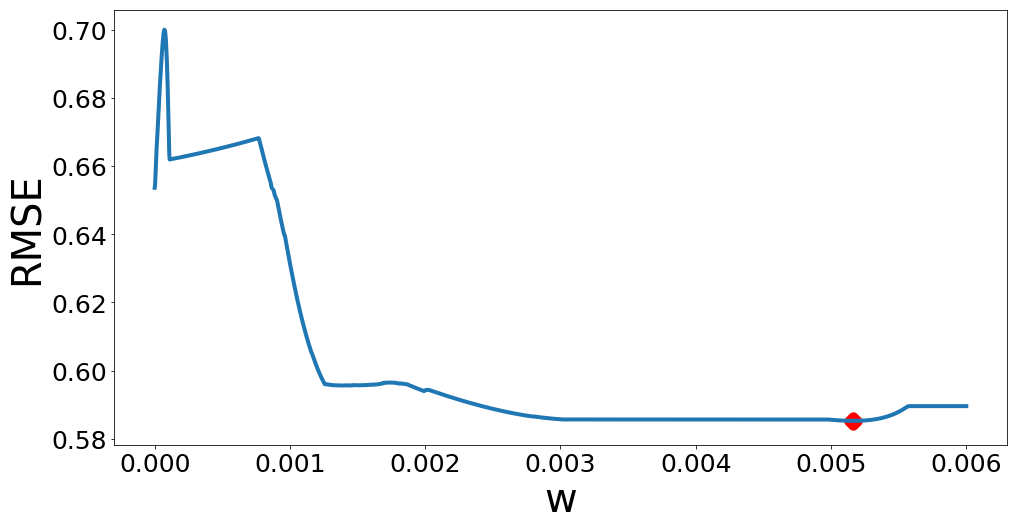

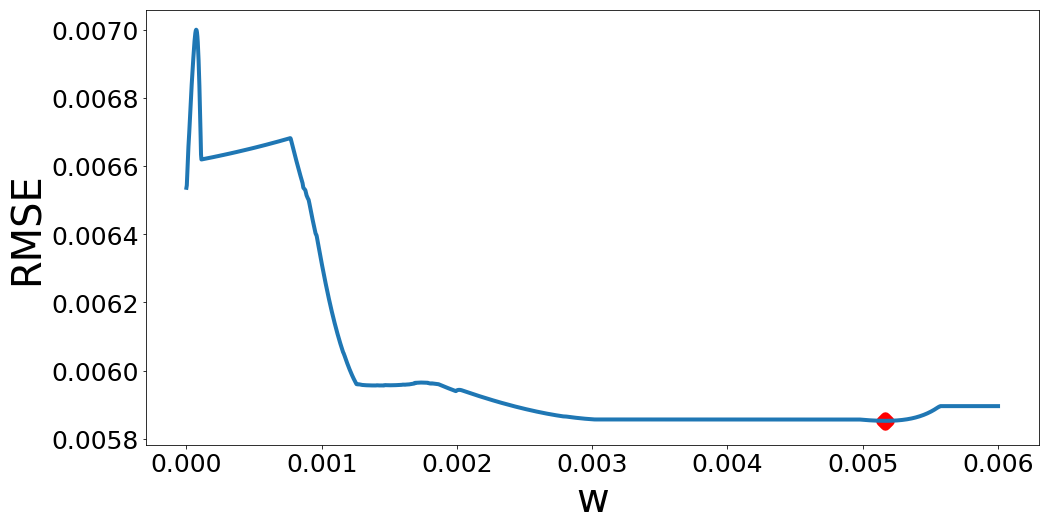

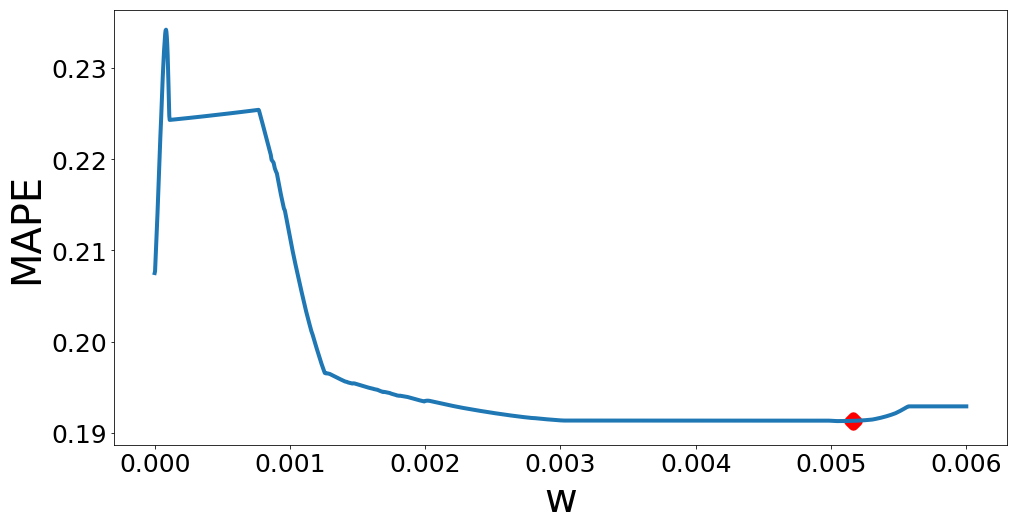

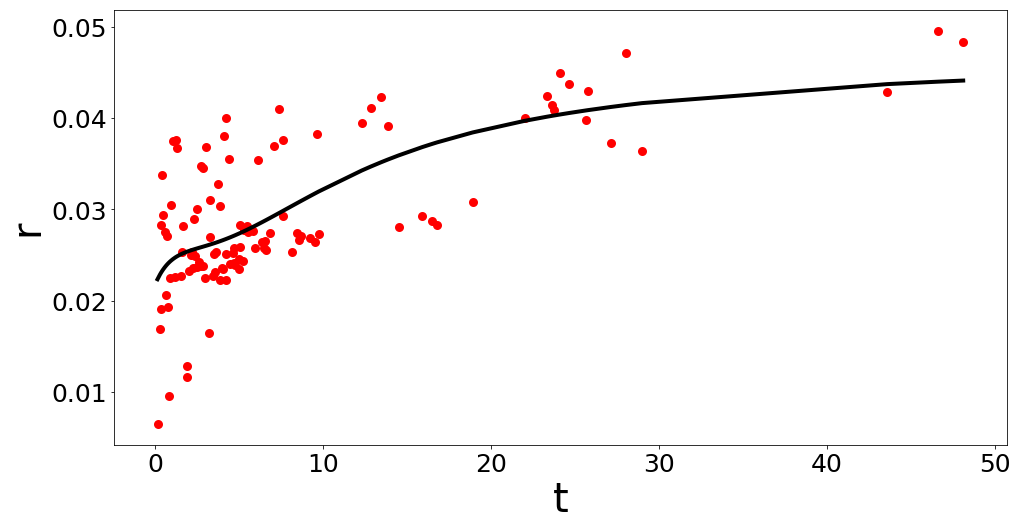

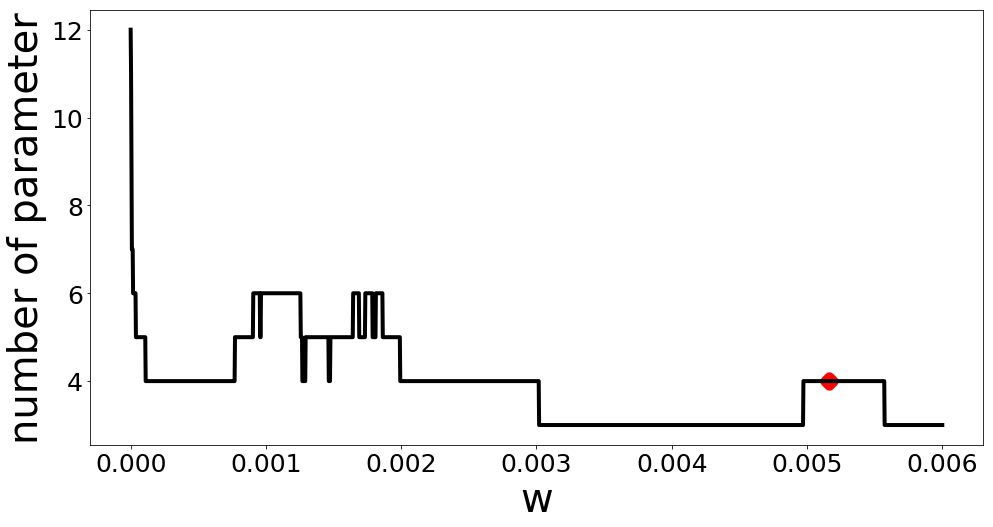

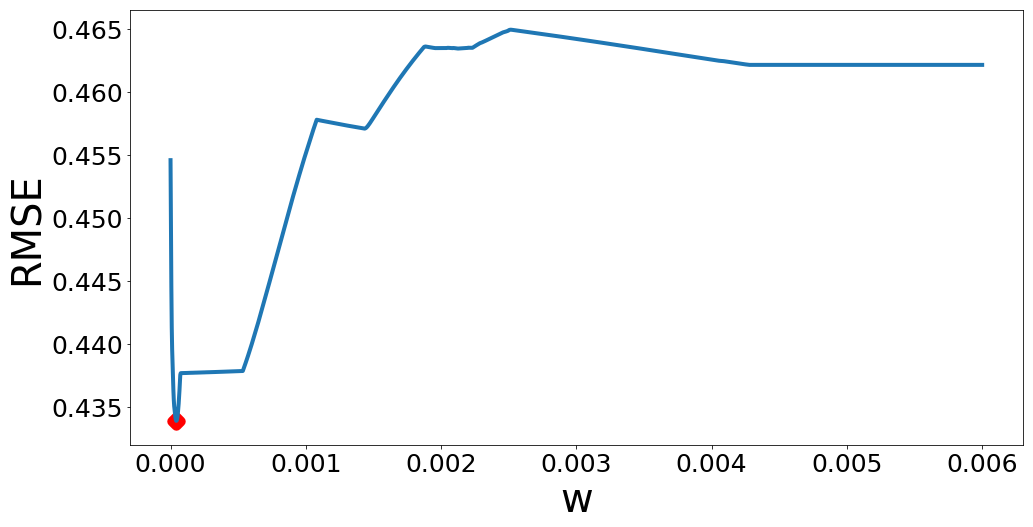

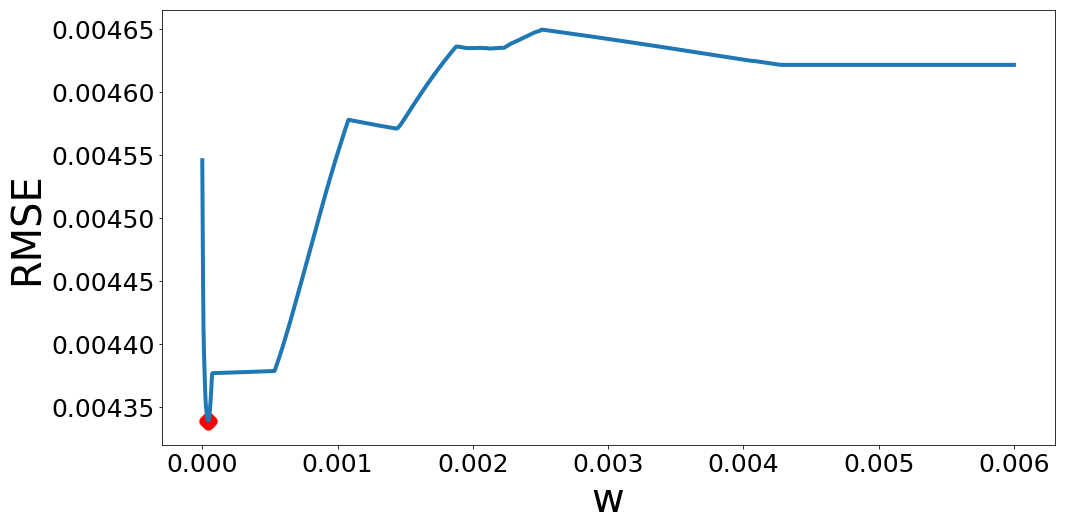

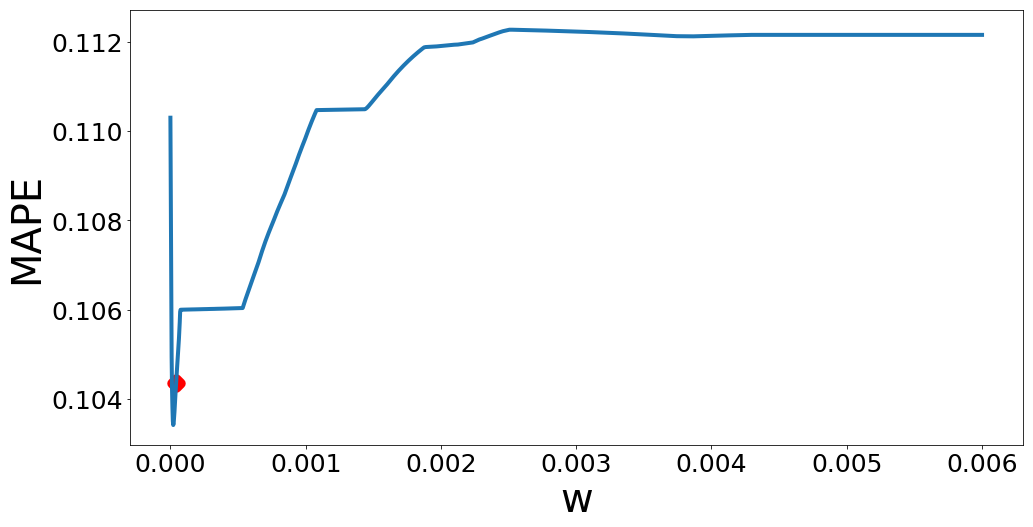

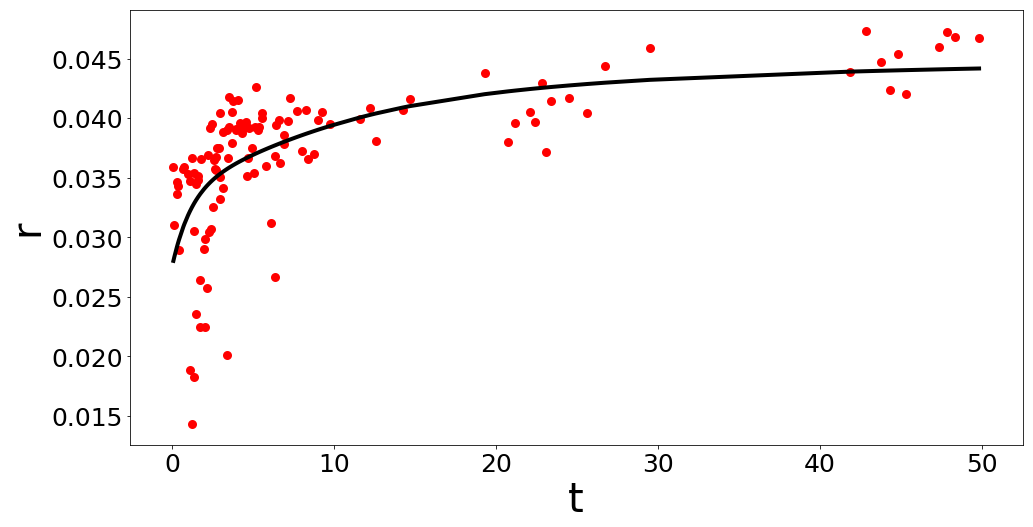

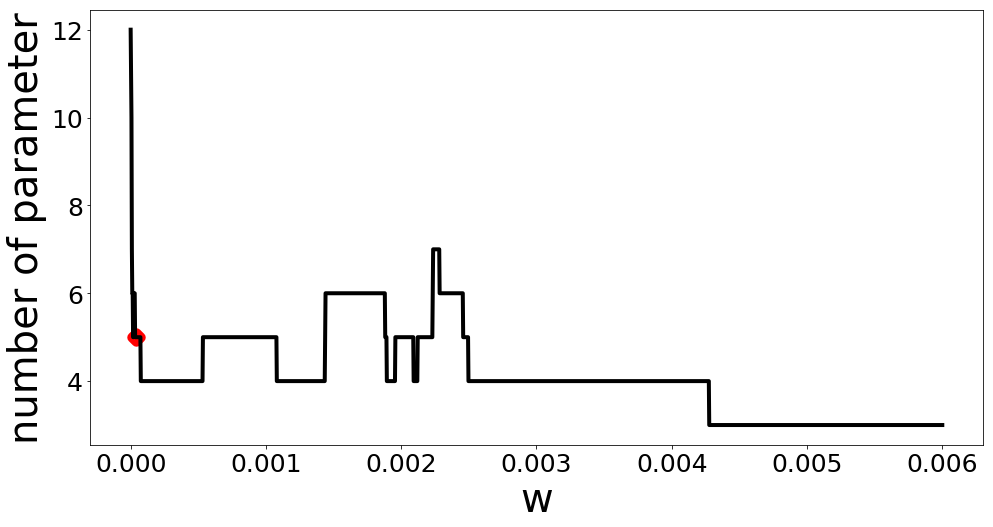

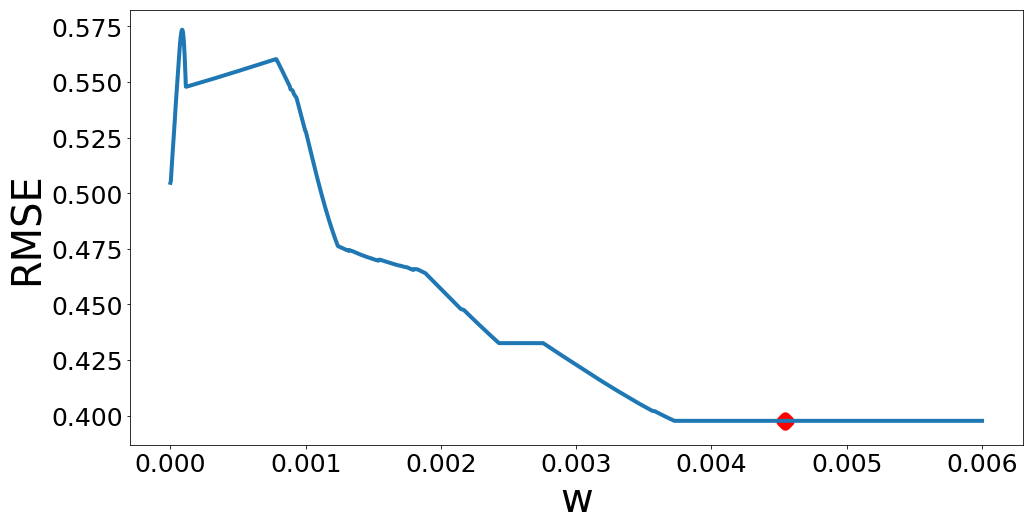

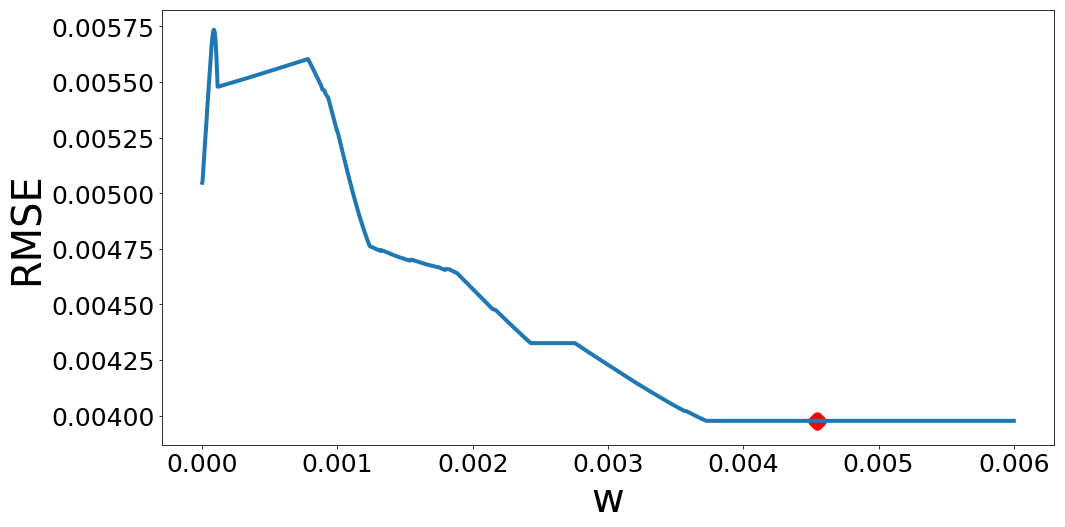

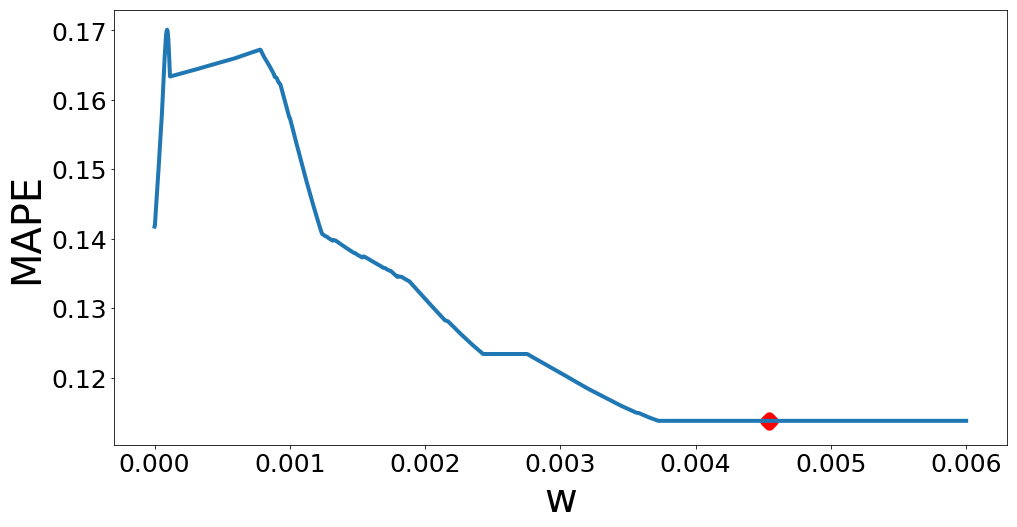

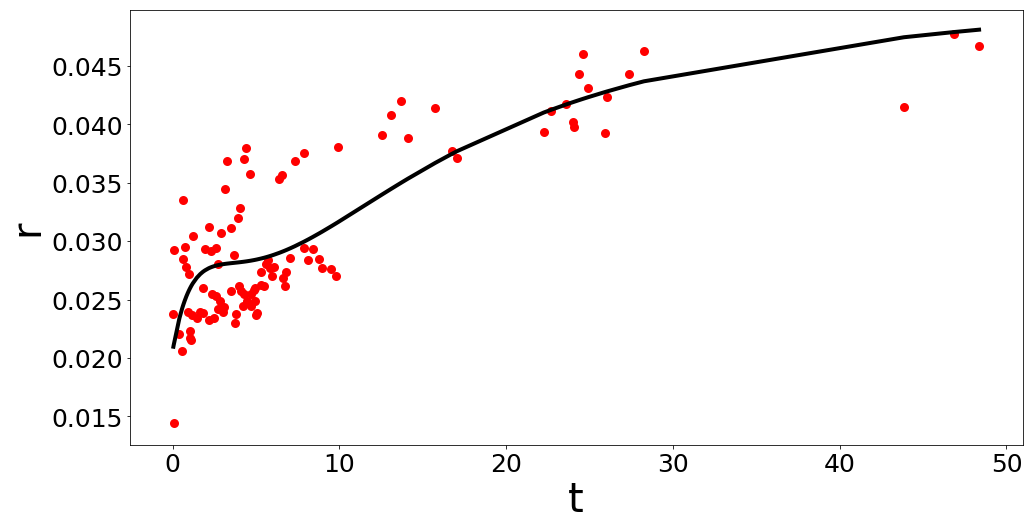

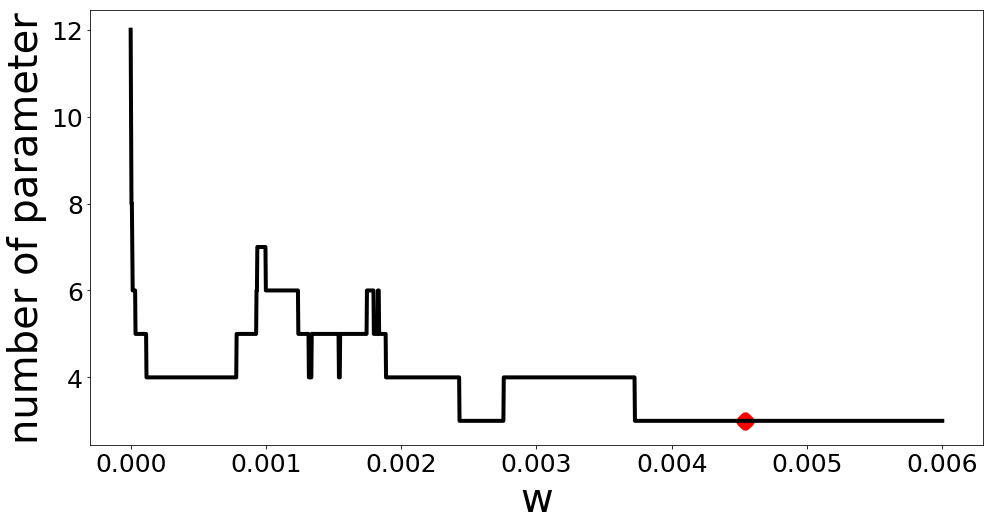

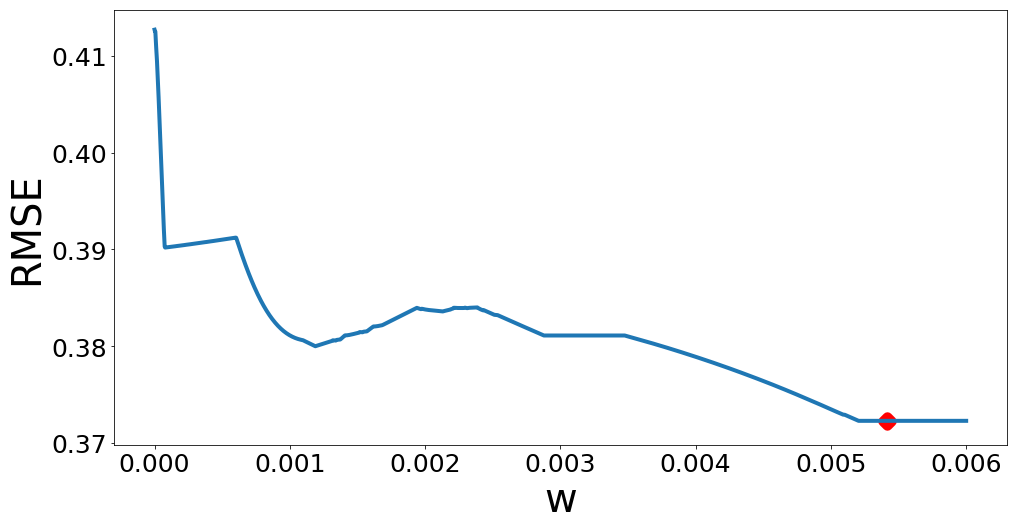

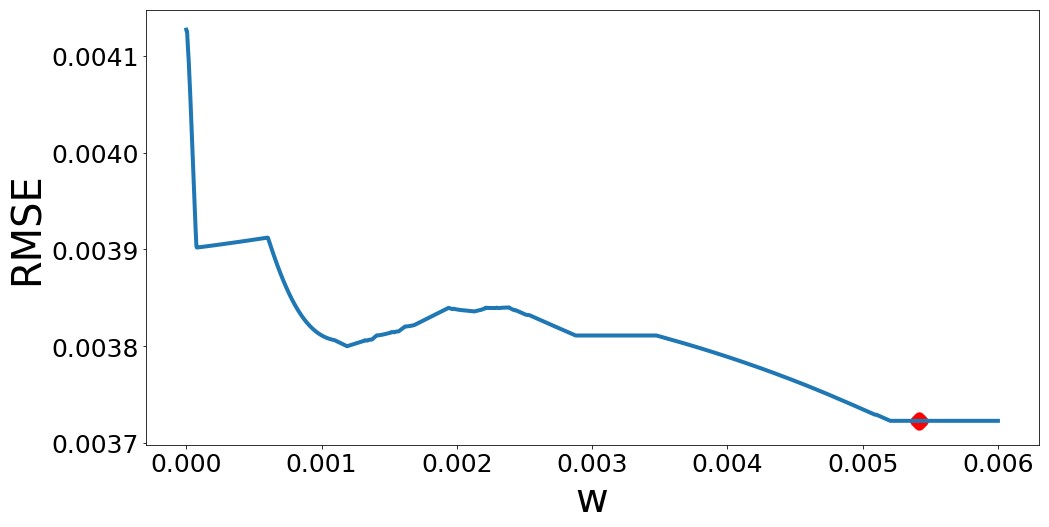

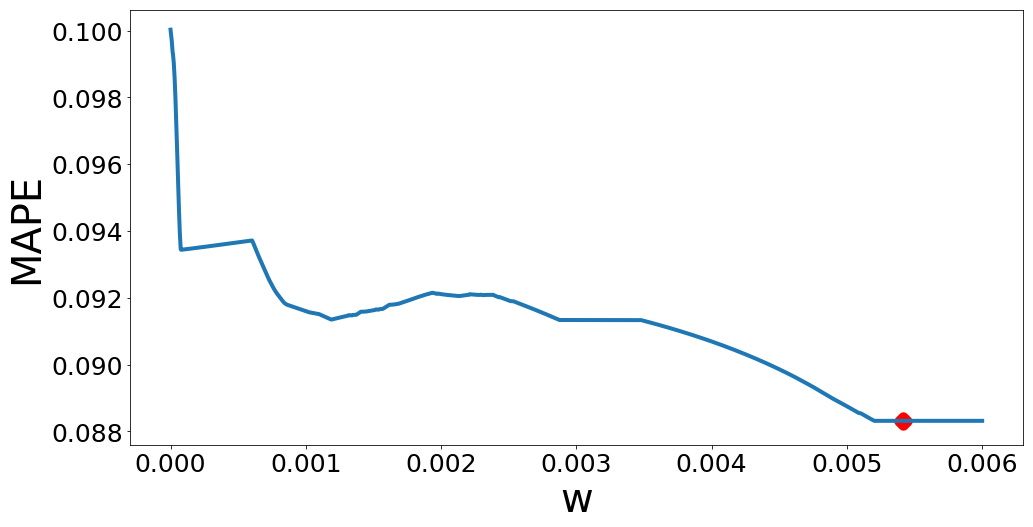

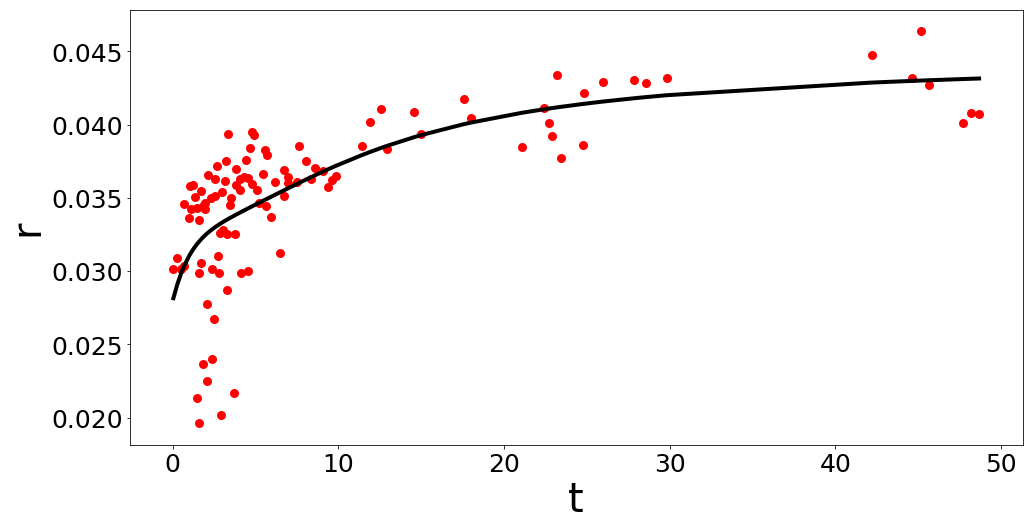

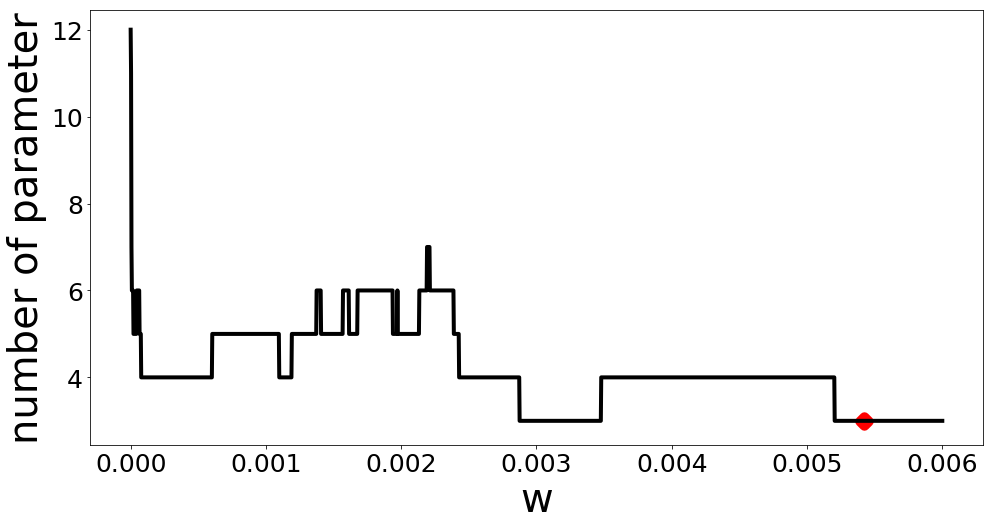

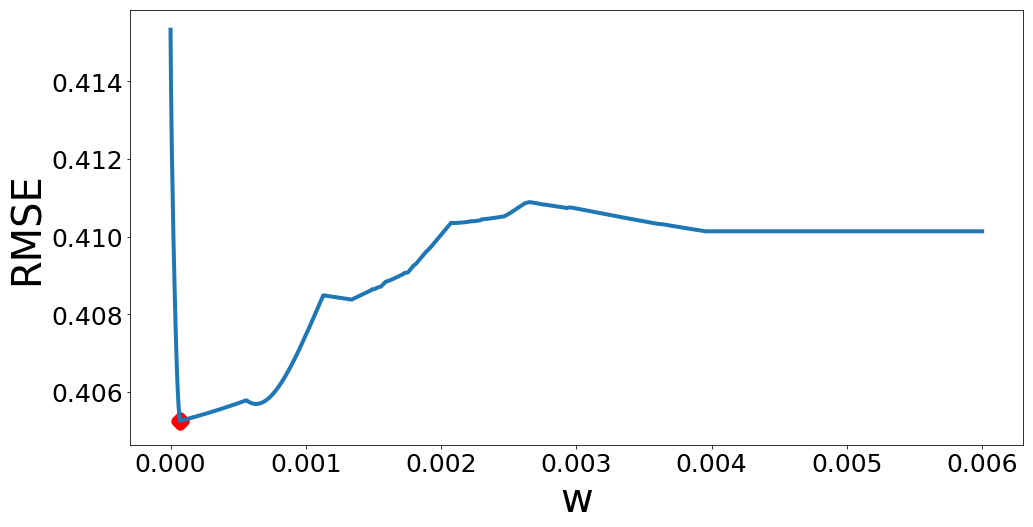

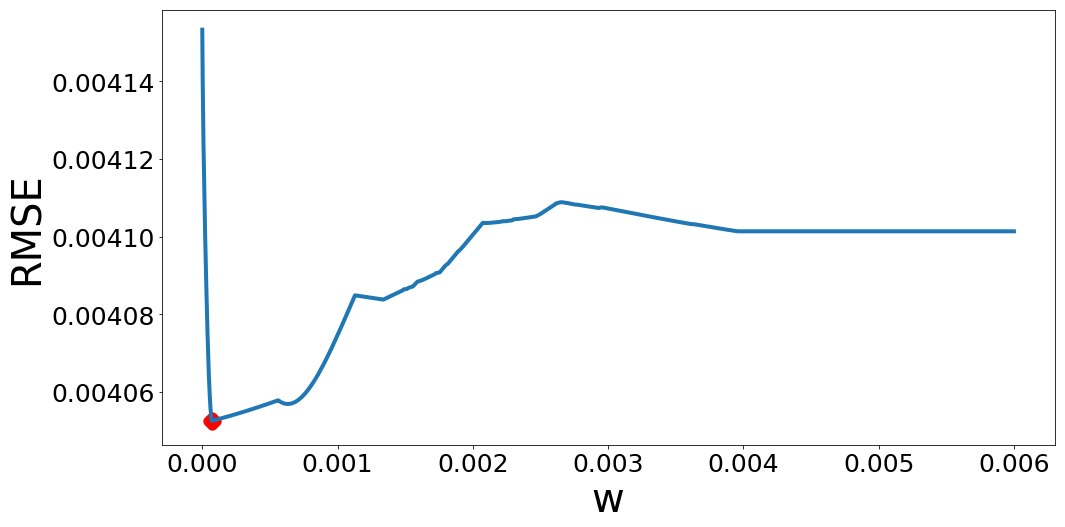

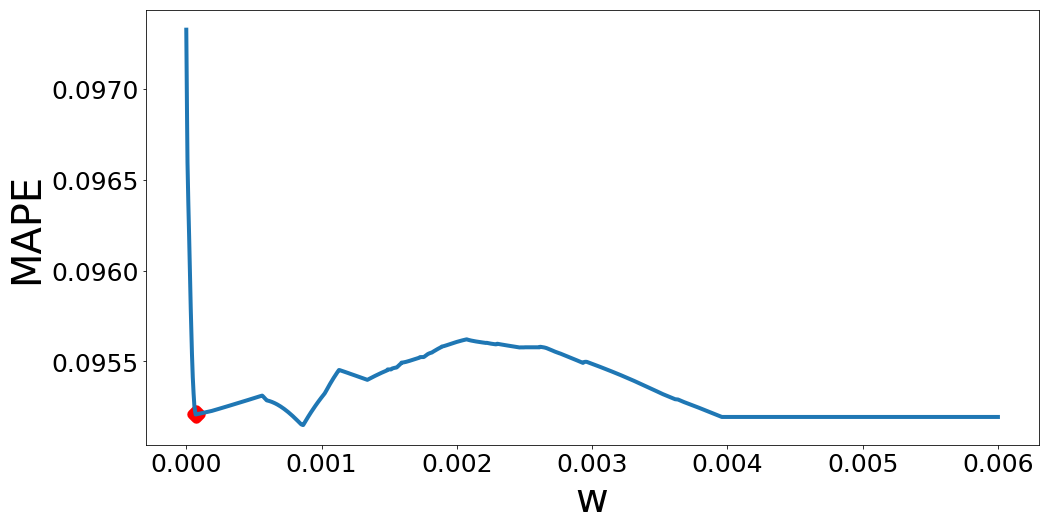

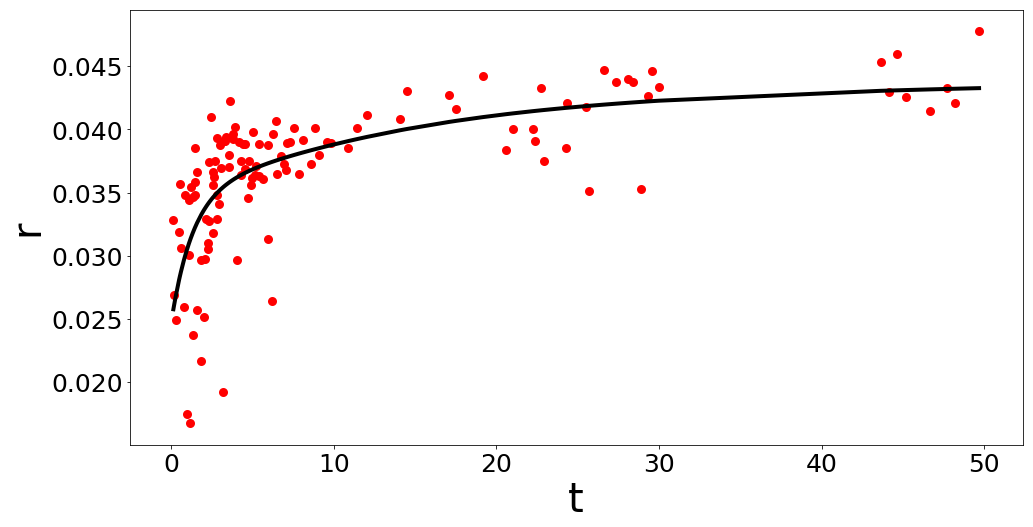

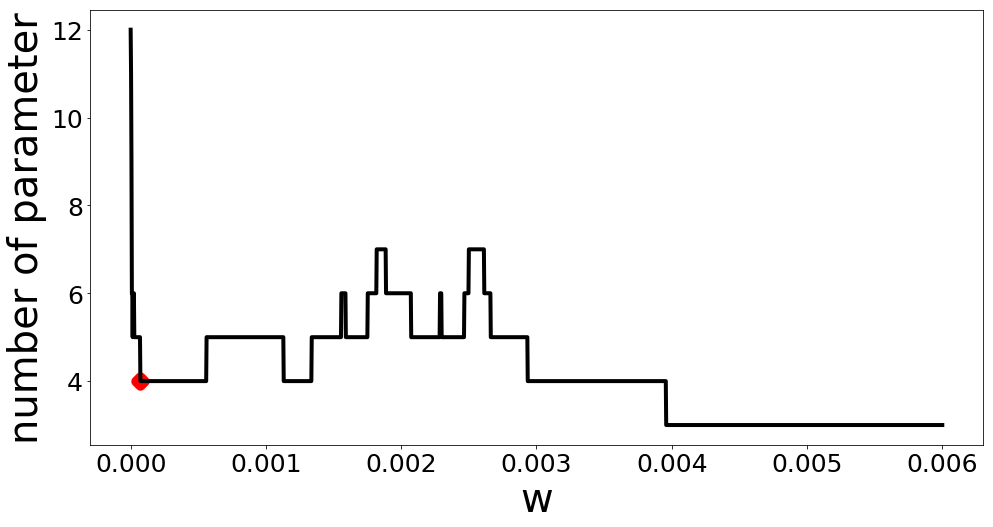

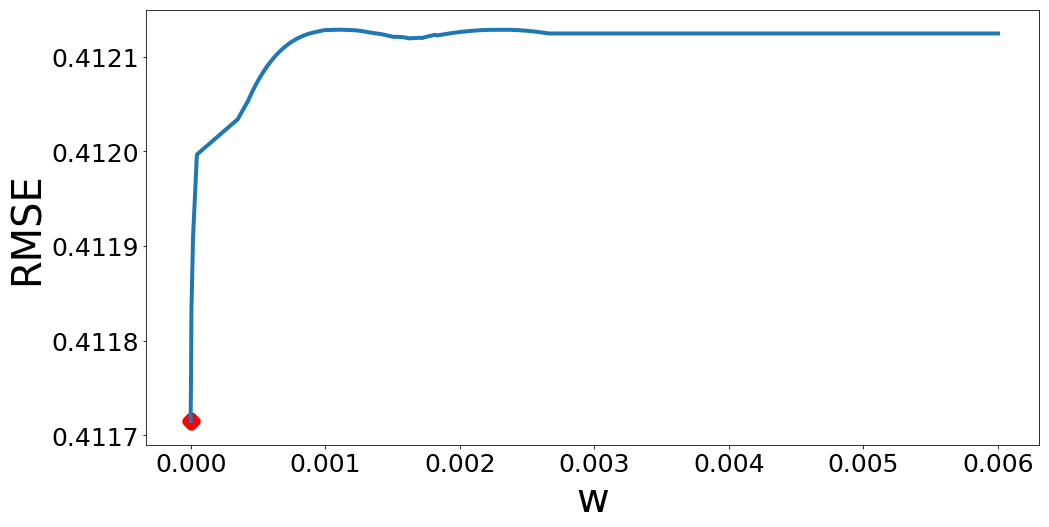

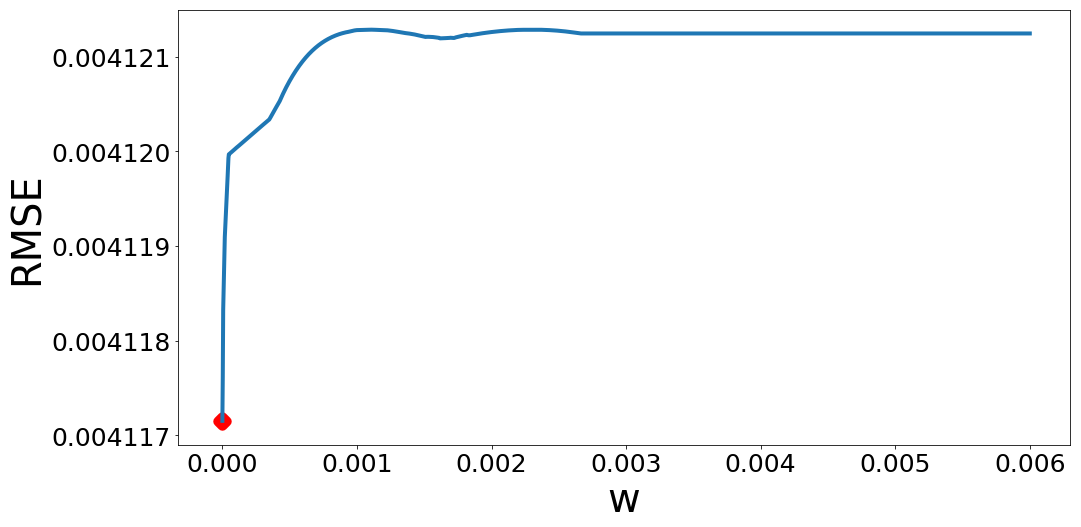

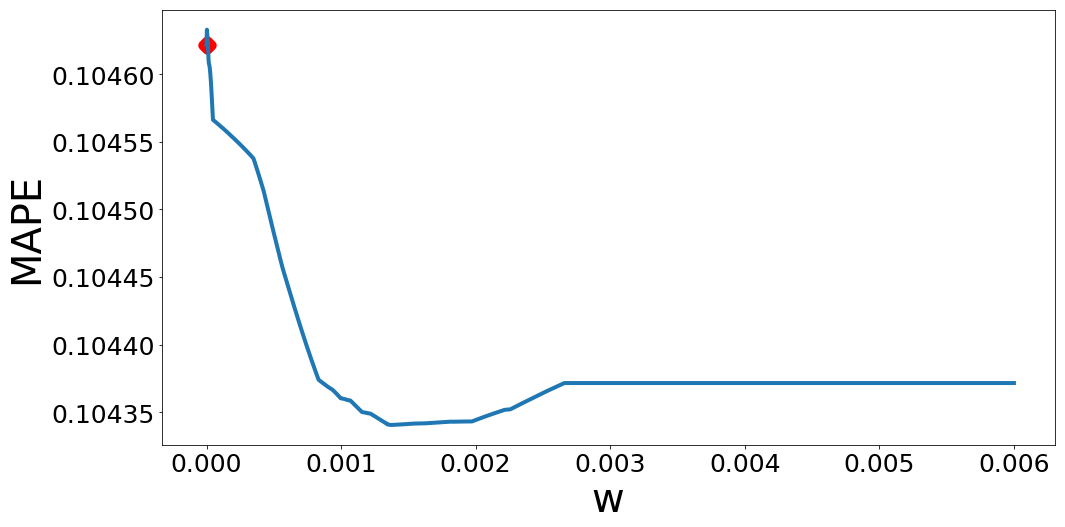

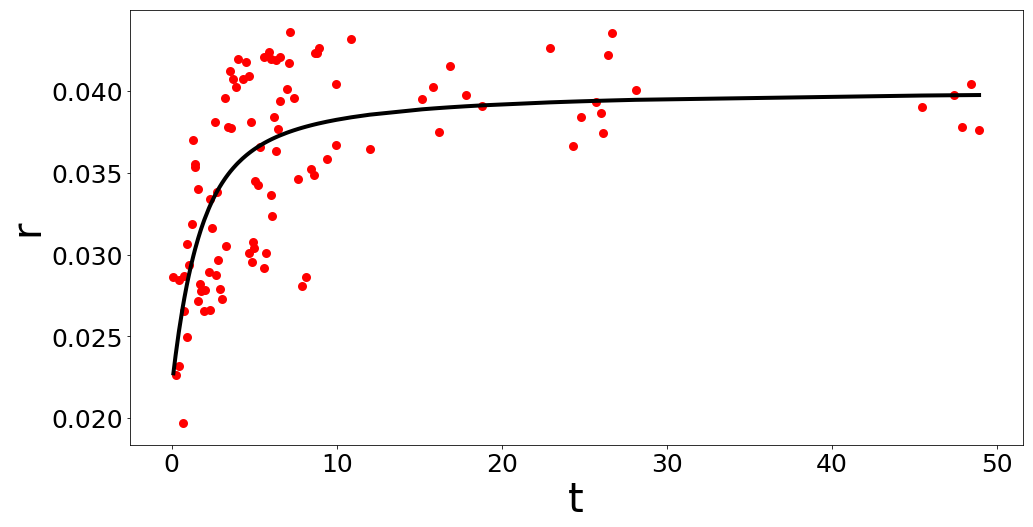

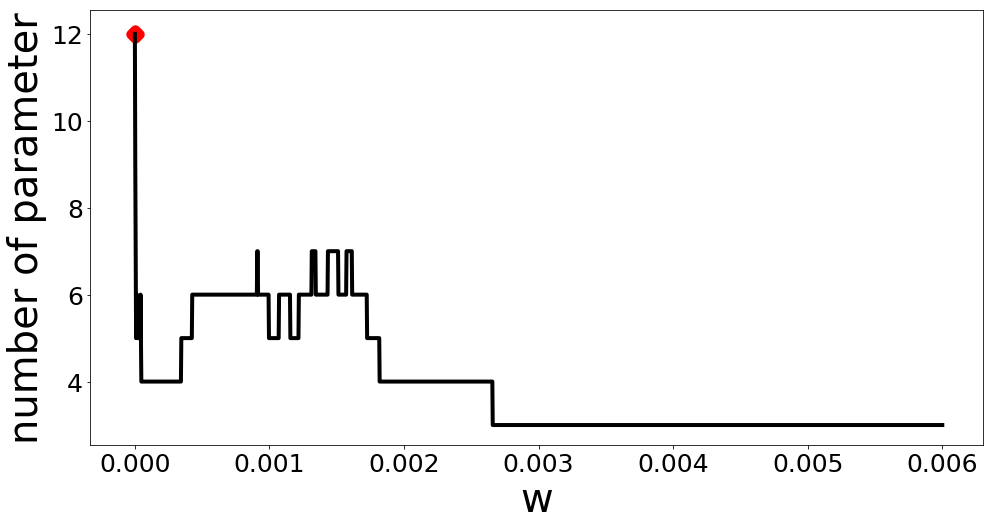

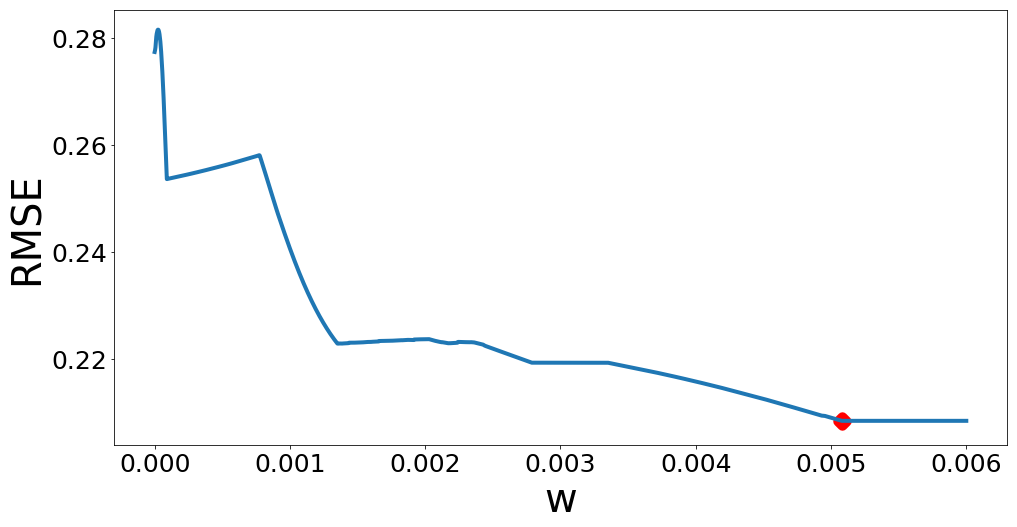

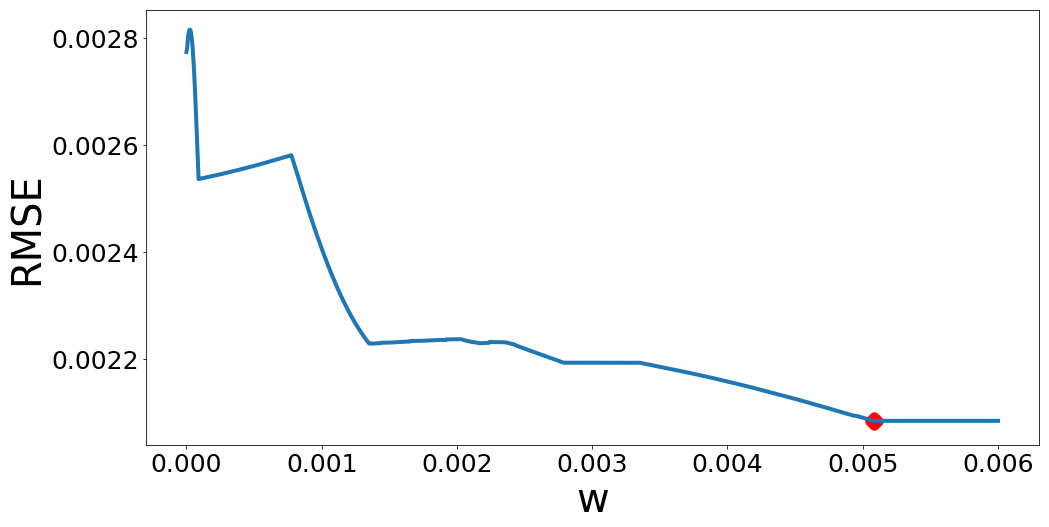

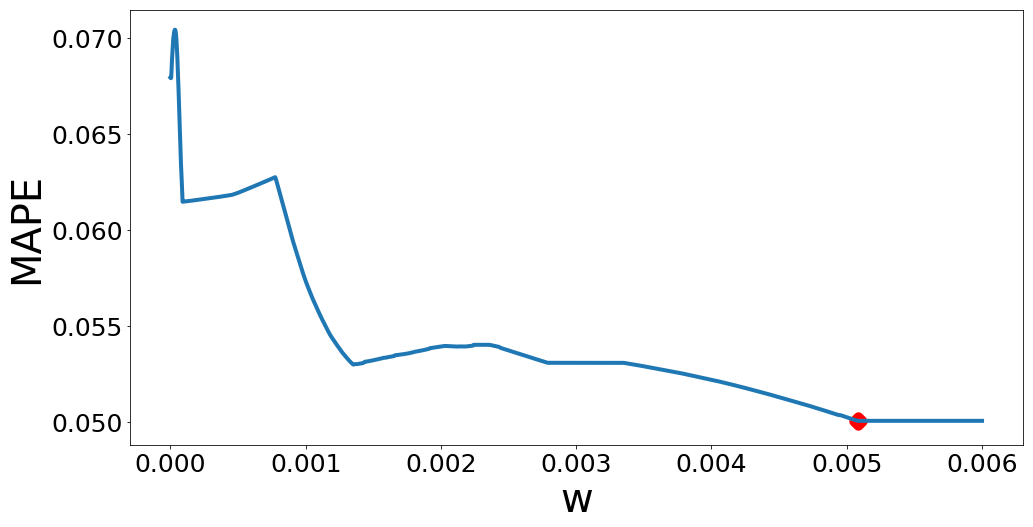

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

data = []
k = 0 
for train_fileName, test_fileName in zip(listdir('./dataSet/train/'),listdir('./dataSet/test/')):
    fit_alpha,fit_intercept ,x1_coef , fit_lasso_coef,train_x,y_fit = get_fig_and_coef(train_fileName,test_fileName)
    L = [train_fileName.split('.x')[0],fit_alpha,fit_intercept ,x1_coef]
    for i in fit_lasso_coef:
        L.append(i)
    data.append(L)
    k += 1
    
    ax.plot(train_x,np.ones(len(train_x))*k , y_fit)
        
plt.xlabel('t')
plt.ylabel('date')
plt.title('r')
plt.savefig(train_fileName.replace('.xlsx','')+ ".jpg")
plt.show()

columns = ['index','lamda']
betas = ['beta'+str(x) for x in range(12)]
for beta in betas:
    columns.append(beta)
pd.DataFrame(data=data,columns = columns).to_csv('para_result.csv')